# <font color=red>Taxi Demand Prediction in New York City</font>

In [1]:
import dask.dataframe as dd #similar to pandas to load data
import folium #open street map #used for visualizing geospatial data
import graphviz 
#graph visualization ~> it is a way of representing structural information as diagrams of abstract graphs and networks

import datetime
import time

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use("nbagg") #matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
import matplotlib.pyplot as plt
import seaborn as sns

import gpxpy.geo #get the haversine distance
from sklearn.cluster import MiniBatchKMeans, KMeans #clustering
import math
import pickle
import os

#download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
#install it in your system and keep the path, migw_path ='installed path'
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import warnings
warnings.filterwarnings("ignore")

# <font color=green>Data Information</font>

<p>
Get the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml (2016 data)
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) 
</p>

- Note: We are considering only the yellow taxis for the time period between **Jan - Mar 2015 & Jan - Mar 2016**

In [2]:
#load the data
month = dd.read_csv("D:/Applied_Ai/Case Studies/Taxi Demand/yellow_tripdata_2015-01.csv")

In [3]:
month.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

In [4]:
month.columns #features

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

<h3><font color=blue>Features in the Dataset :</font></h3>

<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

<h3><font color=blue>1. Pickup Latitude and Pickup Longitude</font></h3>

New York is bounded by the location cordinates (lat,long) - (40.5774, -74.15) & (40.9176,-73.7004), so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [5]:
#plotting pickup cordinates which are outside the bounding box of New-York
#we will collect all the points outside the bounding box of newyork city to outlier_locations

outlier_locations = month[((month.pickup_longitude <= -74.15)|(month.pickup_latitude <= 40.5774)|(month.pickup_longitude >= -73.7004)|(month.pickup_latitude >= 40.9176))]

#creating a map with the a base location
map_view = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

#we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'], j['pickup_longitude']))).add_to(map_view)

In [6]:
map_view

<b>Observation:</b> As you can see above that there are some points just outside the boundary, but there are a few that are in either South america, Mexico or Canada.

<h3><font color=blue>2. Dropoff Latitude and Dropoff Longitude</font></h3>

In [7]:
#plotting dropoff cordinates which are outside the bounding box of New-York 
#we will collect all the points outside the bounding box of newyork city to outlier_locations

outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

#creating a map with the a base location
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

#we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)

map_osm

<b>Observation:</b> The observations here are similar to those obtained while analysing pickup latitude and longitude.

<h3><font color=blue>3. Trip Durations</font></h3>

<p style="font-size:14px">According to NYC Taxi and Limousine Commision Regulations <b style= "color:green">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [8]:
#the timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning
#in our data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix

def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    
    #speed = (trip distance/trip time)*60
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame
    
frame_with_durations = return_with_trip_times(month)   

In [9]:
#save the csv file frame_with_durations
#frame_with_durations.to_csv("D:/Applied_Ai/Case Studies/Taxi Demand/frame_with_durations.csv")

<IPython.core.display.Javascript object>


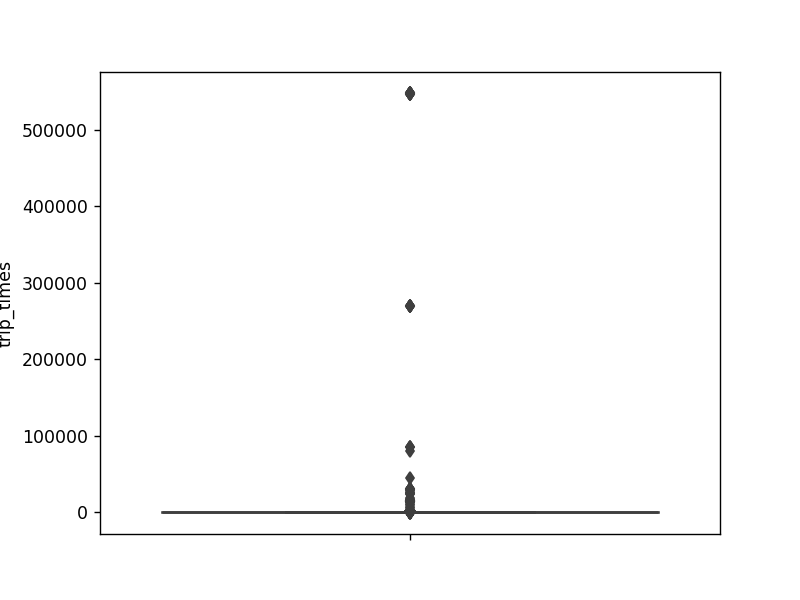

In [10]:
#the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data = frame_with_durations)
plt.show()

In [11]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,110,10):
    trip = frame_with_durations["trip_times"].values
    trip = np.sort(trip, axis=None)
    print("{} PERCENTILE VALUE IS {}".format(i,np.percentile(trip,i))) #np.percentile = trip[int(len(trip)*(float(i)/100))]

0 PERCENTILE VALUE IS -1211.0166666666667
10 PERCENTILE VALUE IS 3.8333333333333335
20 PERCENTILE VALUE IS 5.383333333333334
30 PERCENTILE VALUE IS 6.816666666666666
40 PERCENTILE VALUE IS 8.3
50 PERCENTILE VALUE IS 9.95
60 PERCENTILE VALUE IS 11.866666666666667
70 PERCENTILE VALUE IS 14.283333333333333
80 PERCENTILE VALUE IS 17.633333333333333
90 PERCENTILE VALUE IS 23.45
100 PERCENTILE VALUE IS 548555.6333333333


In [12]:
#looking further from the 90th percecntile
for i in range(90,101):
    trip = frame_with_durations["trip_times"].values
    trip = np.sort(trip, axis=None)
    print("{} PERCENTILE VALUE IS {}".format(i,np.percentile(trip,i))) #np.percentile = trip[int(len(trip)*(float(i)/100))]

90 PERCENTILE VALUE IS 23.45
91 PERCENTILE VALUE IS 24.35
92 PERCENTILE VALUE IS 25.383333333333333
93 PERCENTILE VALUE IS 26.55
94 PERCENTILE VALUE IS 27.933333333333334
95 PERCENTILE VALUE IS 29.583333333333332
96 PERCENTILE VALUE IS 31.68333333333333
97 PERCENTILE VALUE IS 34.46666666666667
98 PERCENTILE VALUE IS 38.71666666666667
99 PERCENTILE VALUE IS 46.75
100 PERCENTILE VALUE IS 548555.6333333333


In [13]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified = frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

<IPython.core.display.Javascript object>


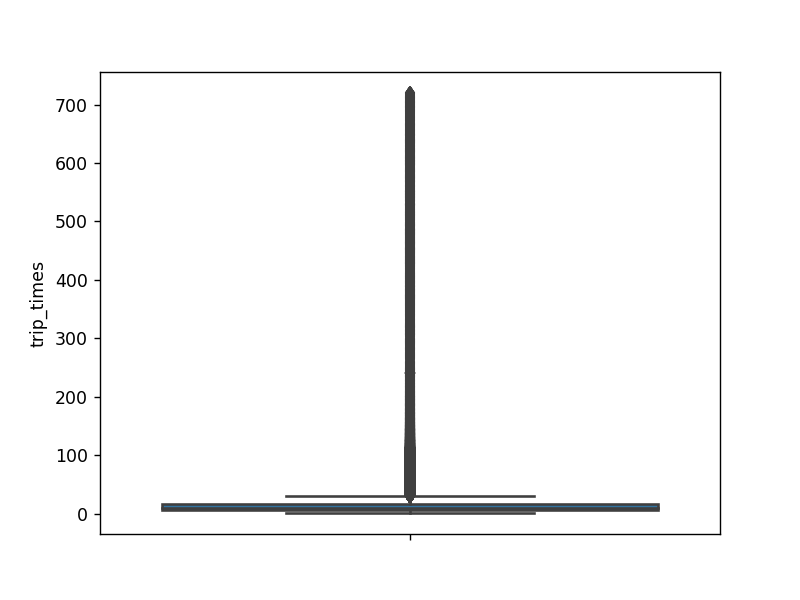

In [14]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data = frame_with_durations_modified)
plt.show()

<IPython.core.display.Javascript object>


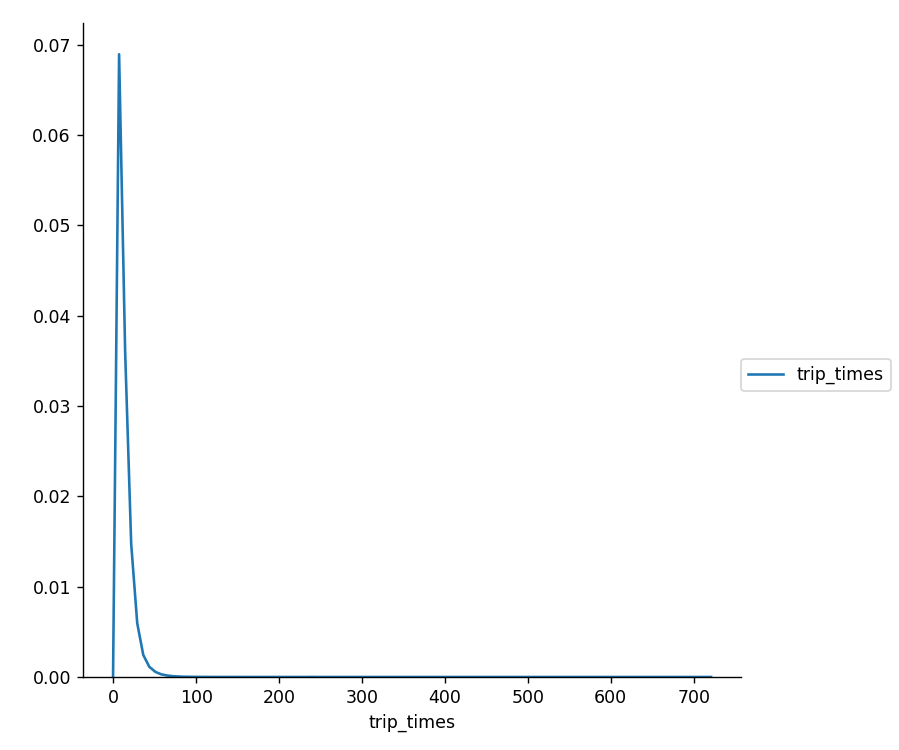

In [15]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6).map(sns.kdeplot,"trip_times").add_legend();
plt.show()

In [16]:
#converting the values to log-values to chec for log-normal
frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]

<IPython.core.display.Javascript object>


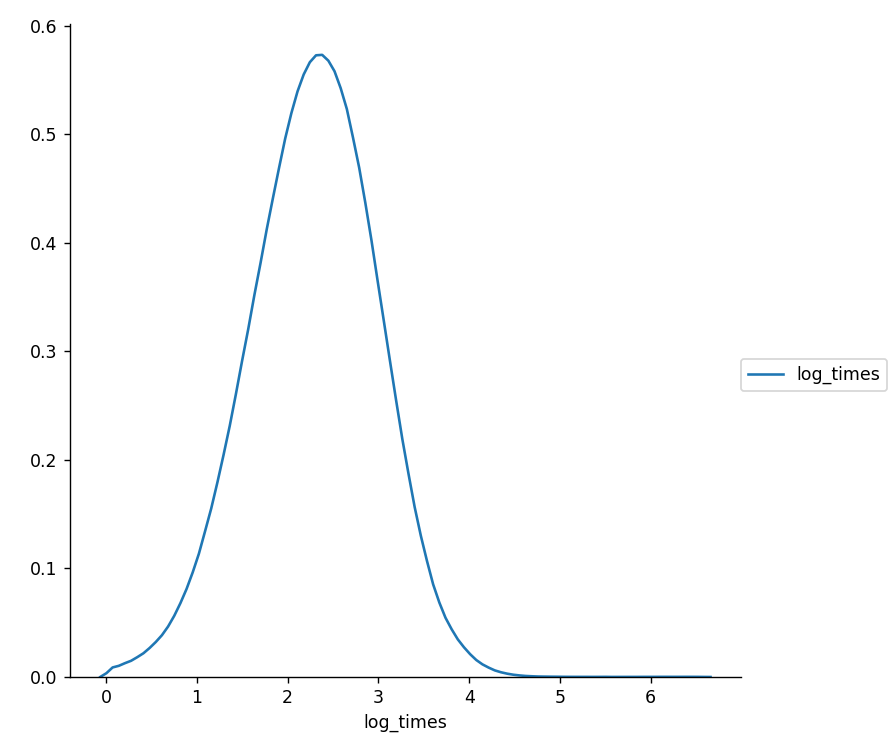

In [17]:
#pdf log_values
sns.FacetGrid(frame_with_durations_modified,size=6).map(sns.kdeplot,"log_times").add_legend();
plt.show()

<IPython.core.display.Javascript object>


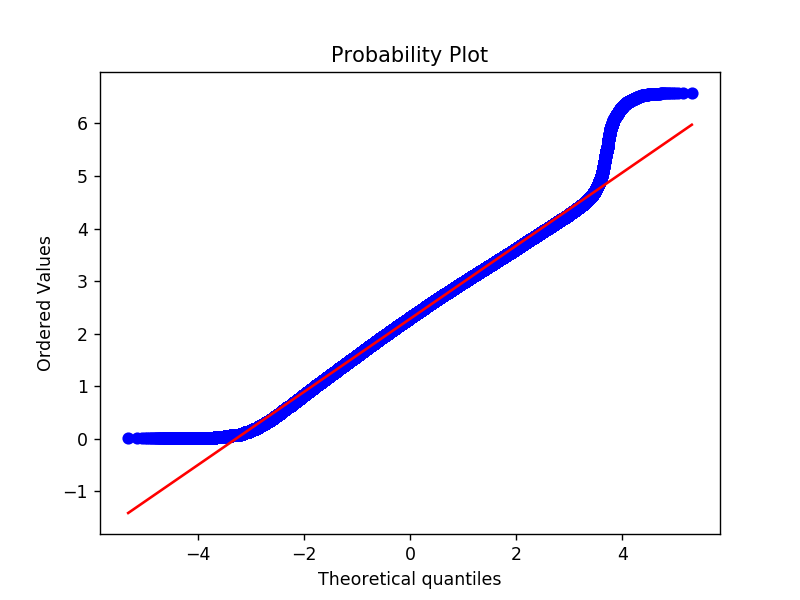

In [18]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

<h3><font color=blue>4. Speed</font></h3>

<IPython.core.display.Javascript object>


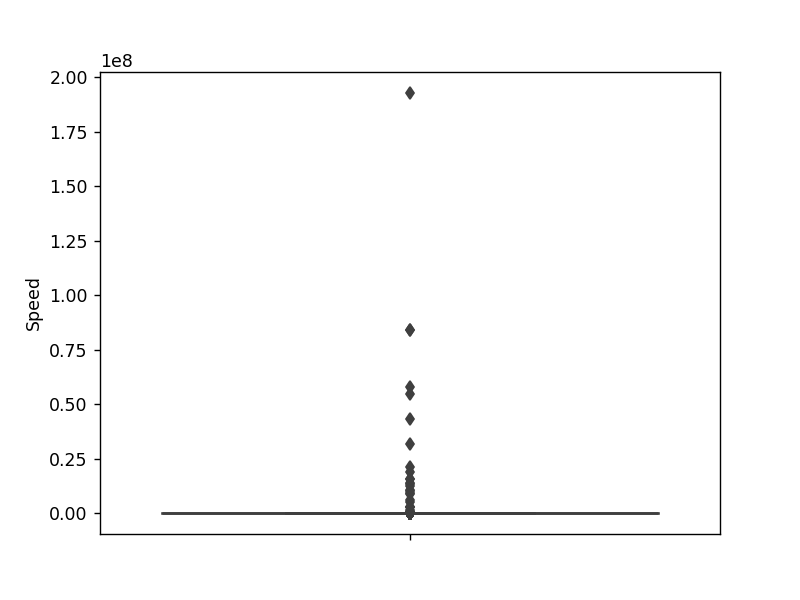

In [19]:
#check for any outliers in the data after trip duration outliers removed
sns.boxplot(y="Speed", data=frame_with_durations_modified)
plt.show()

In [20]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,110,10):
    trip = frame_with_durations_modified["Speed"].values
    trip = np.sort(trip, axis=None)
    print("{} PERCENTILE VALUE IS {}".format(i,np.percentile(trip,i)))

0 PERCENTILE VALUE IS 0.0
10 PERCENTILE VALUE IS 6.409495548961425
20 PERCENTILE VALUE IS 7.80952380952381
30 PERCENTILE VALUE IS 8.929133858267717
40 PERCENTILE VALUE IS 9.98019801980198
50 PERCENTILE VALUE IS 11.06865671641791
60 PERCENTILE VALUE IS 12.286689419795222
70 PERCENTILE VALUE IS 13.796407185628745
80 PERCENTILE VALUE IS 15.963224893917962
90 PERCENTILE VALUE IS 20.186915887850468
100 PERCENTILE VALUE IS 192857142.85714284


In [21]:
#looking further from the 90th percecntile
for i in range(90,101):
    speed = frame_with_durations_modified["Speed"].values
    speed = np.sort(speed, axis=None)
    print("{} PERCENTILE VALUE IS {}".format(i,np.percentile(speed,i))) #np.percentile = speed[int(len(speed)*(float(i)/100))]

90 PERCENTILE VALUE IS 20.186915887850468
91 PERCENTILE VALUE IS 20.916454400875093
92 PERCENTILE VALUE IS 21.752988047808763
93 PERCENTILE VALUE IS 22.721893491124263
94 PERCENTILE VALUE IS 23.844155844155843
95 PERCENTILE VALUE IS 25.182552504038775
96 PERCENTILE VALUE IS 26.80851063829787
97 PERCENTILE VALUE IS 28.84304932735426
98 PERCENTILE VALUE IS 31.591128254580514
99 PERCENTILE VALUE IS 35.75135055113604
100 PERCENTILE VALUE IS 192857142.85714284


In [22]:
#looking further from the 99th percecntile
for i in np.arange(0.0,1.1,0.1):
    speed = frame_with_durations_modified["Speed"].values
    speed = np.sort(speed, axis=None)
    print("{} PERCENTILE VALUE IS {}".format(i+99,np.percentile(speed,i+99))) #np.percentile = speed[int(len(speed)*(float(i)/100))]

99.0 PERCENTILE VALUE IS 35.75135055113604
99.1 PERCENTILE VALUE IS 36.31081290376664
99.2 PERCENTILE VALUE IS 36.91470054446461
99.3 PERCENTILE VALUE IS 37.588235294117645
99.4 PERCENTILE VALUE IS 38.330334294788756
99.5 PERCENTILE VALUE IS 39.17580011612381
99.6 PERCENTILE VALUE IS 40.15384615384615
99.7 PERCENTILE VALUE IS 41.338029086798095
99.8 PERCENTILE VALUE IS 42.866243893093184
99.9 PERCENTILE VALUE IS 45.310675074725154
100.0 PERCENTILE VALUE IS 192857142.85714284


In [23]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified = frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [24]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

<b style='font-size:15px'>The Avg speed in New York is 12.45 miles/hr, so a cab driver can travel <font color='blue'>2 miles per 10 min on avg.</font> </b>

<h3><font color=blue>5. Trip Distance</font></h3>

<IPython.core.display.Javascript object>


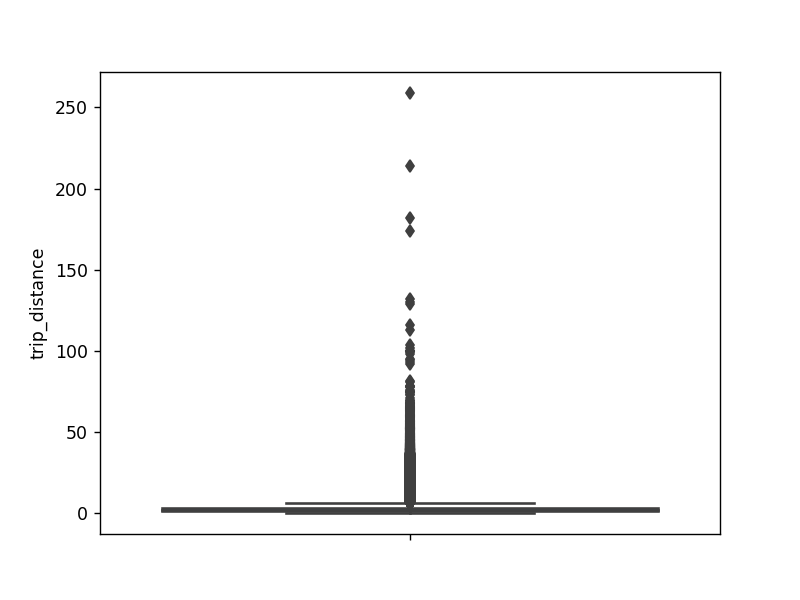

In [25]:
#up to now we have removed the outliers based on trip durations and cab speeds
#lets try if there are any outliers in trip distances

#box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data=frame_with_durations_modified)
plt.show()

In [26]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,110,10):
    trip_dist = frame_with_durations_modified["trip_distance"].values
    trip_dist = np.sort(trip_dist, axis=None)
    print("{} PERCENTILE VALUE IS {}".format(i,np.percentile(trip_dist,i)))

0 PERCENTILE VALUE IS 0.01
10 PERCENTILE VALUE IS 0.66
20 PERCENTILE VALUE IS 0.9
30 PERCENTILE VALUE IS 1.1
40 PERCENTILE VALUE IS 1.39
50 PERCENTILE VALUE IS 1.69
60 PERCENTILE VALUE IS 2.07
70 PERCENTILE VALUE IS 2.6
80 PERCENTILE VALUE IS 3.6
90 PERCENTILE VALUE IS 5.97
100 PERCENTILE VALUE IS 258.9


In [27]:
#looking further from the 90th percecntile
for i in range(90,101):
    trip_dist = frame_with_durations_modified["trip_distance"].values
    trip_dist = np.sort(trip_dist, axis=None)
    print("{} PERCENTILE VALUE IS {}".format(i,np.percentile(trip_dist,i)))

90 PERCENTILE VALUE IS 5.97
91 PERCENTILE VALUE IS 6.45
92 PERCENTILE VALUE IS 7.07
93 PERCENTILE VALUE IS 7.85
94 PERCENTILE VALUE IS 8.72
95 PERCENTILE VALUE IS 9.6
96 PERCENTILE VALUE IS 10.6
97 PERCENTILE VALUE IS 12.1
98 PERCENTILE VALUE IS 16.03
99 PERCENTILE VALUE IS 18.17
100 PERCENTILE VALUE IS 258.9


In [28]:
#looking further from the 99th percecntile
for i in np.arange(0.0,1.1,0.1):
    trip_dist = frame_with_durations_modified["trip_distance"].values
    trip_dist = np.sort(trip_dist, axis=None)
    print("{} PERCENTILE VALUE IS {}".format(i+99,np.percentile(trip_dist,i+99)))

99.0 PERCENTILE VALUE IS 18.17
99.1 PERCENTILE VALUE IS 18.37
99.2 PERCENTILE VALUE IS 18.6
99.3 PERCENTILE VALUE IS 18.83
99.4 PERCENTILE VALUE IS 19.13
99.5 PERCENTILE VALUE IS 19.5
99.6 PERCENTILE VALUE IS 19.96
99.7 PERCENTILE VALUE IS 20.5
99.8 PERCENTILE VALUE IS 21.22
99.9 PERCENTILE VALUE IS 22.57
100.0 PERCENTILE VALUE IS 258.9


In [29]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

<IPython.core.display.Javascript object>


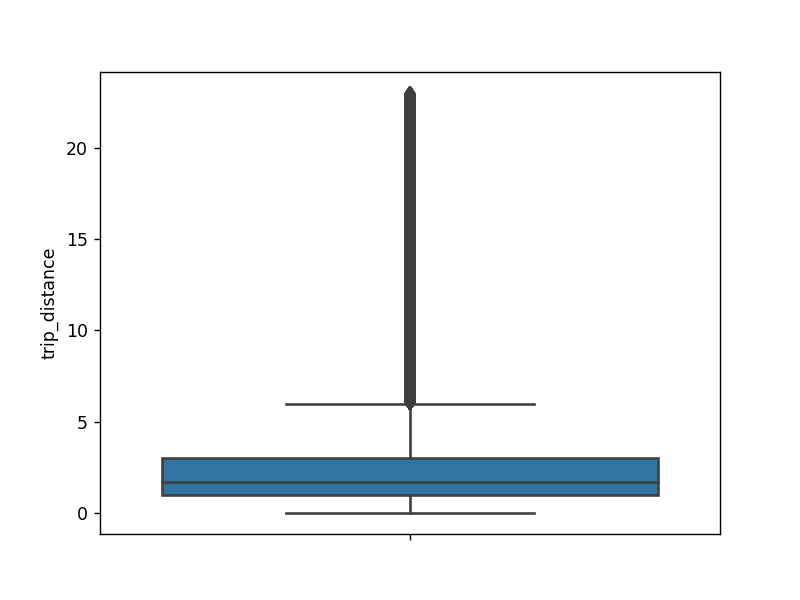

In [30]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

<h3><font color=blue>6. Total Fare</font></h3>

<IPython.core.display.Javascript object>


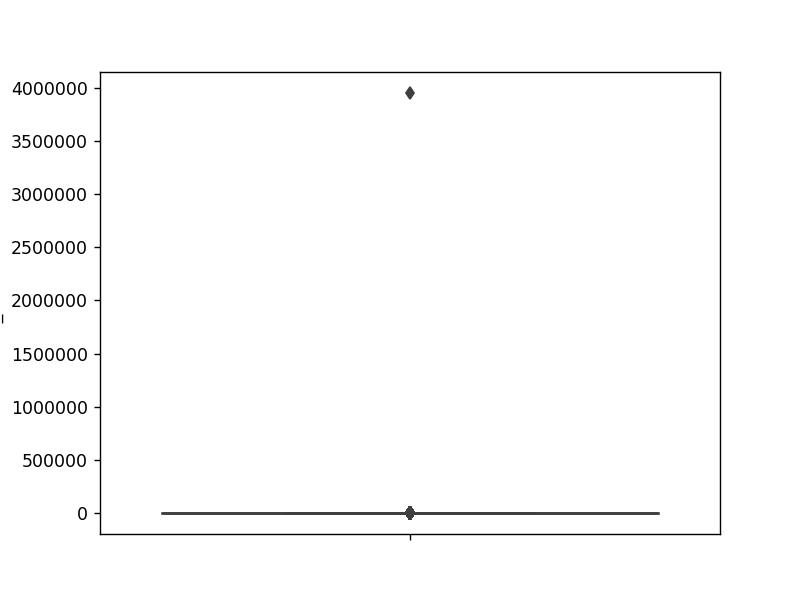

In [31]:
#up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
#lets try if there are any outliers in based on the total_amount

#box-plot showing outliers in fare
sns.boxplot(y="total_amount", data=frame_with_durations_modified)
plt.show()

In [32]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,110,10):
    trip_fare = frame_with_durations_modified["total_amount"].values
    trip_fare = np.sort(trip_fare, axis=None)
    print("{} PERCENTILE VALUE IS {}".format(i,np.percentile(trip_fare,i)))

0 PERCENTILE VALUE IS -242.55
10 PERCENTILE VALUE IS 6.3
20 PERCENTILE VALUE IS 7.799999999999999
30 PERCENTILE VALUE IS 8.8
40 PERCENTILE VALUE IS 9.8
50 PERCENTILE VALUE IS 11.16
60 PERCENTILE VALUE IS 12.8
70 PERCENTILE VALUE IS 14.8
80 PERCENTILE VALUE IS 18.3
90 PERCENTILE VALUE IS 25.8
100 PERCENTILE VALUE IS 3950611.6


In [33]:
#looking further from the 90th percecntile
for i in range(90,101):
    trip_fare = frame_with_durations_modified["total_amount"].values
    trip_fare = np.sort(trip_fare, axis=None)
    print("{} PERCENTILE VALUE IS {}".format(i,np.percentile(trip_fare,i)))

90 PERCENTILE VALUE IS 25.8
91 PERCENTILE VALUE IS 27.3
92 PERCENTILE VALUE IS 29.3
93 PERCENTILE VALUE IS 31.800000000000004
94 PERCENTILE VALUE IS 34.8
95 PERCENTILE VALUE IS 38.53
96 PERCENTILE VALUE IS 42.6
97 PERCENTILE VALUE IS 48.13
98 PERCENTILE VALUE IS 58.13
99 PERCENTILE VALUE IS 66.13
100 PERCENTILE VALUE IS 3950611.6


In [34]:
#looking further from the 99th percecntile
for i in np.arange(0.0,1.1,0.1):
    trip_fare = frame_with_durations_modified["total_amount"].values
    trip_fare = np.sort(trip_fare, axis=None)
    print("{} PERCENTILE VALUE IS {}".format(i+99,np.percentile(trip_fare,i+99)))

99.0 PERCENTILE VALUE IS 66.13
99.1 PERCENTILE VALUE IS 68.13
99.2 PERCENTILE VALUE IS 69.6
99.3 PERCENTILE VALUE IS 69.6
99.4 PERCENTILE VALUE IS 69.73
99.5 PERCENTILE VALUE IS 69.75
99.6 PERCENTILE VALUE IS 69.76
99.7 PERCENTILE VALUE IS 72.58
99.8 PERCENTILE VALUE IS 75.35
99.9 PERCENTILE VALUE IS 88.2722400000319
100.0 PERCENTILE VALUE IS 3950611.6


<b>Observation:</b> As even the 99.9th percentile value doesnt look like an outlier, as there is not much difference between the 99.8th percentile and 99.9th percentile value. We move on to do graphical analyis.

<IPython.core.display.Javascript object>


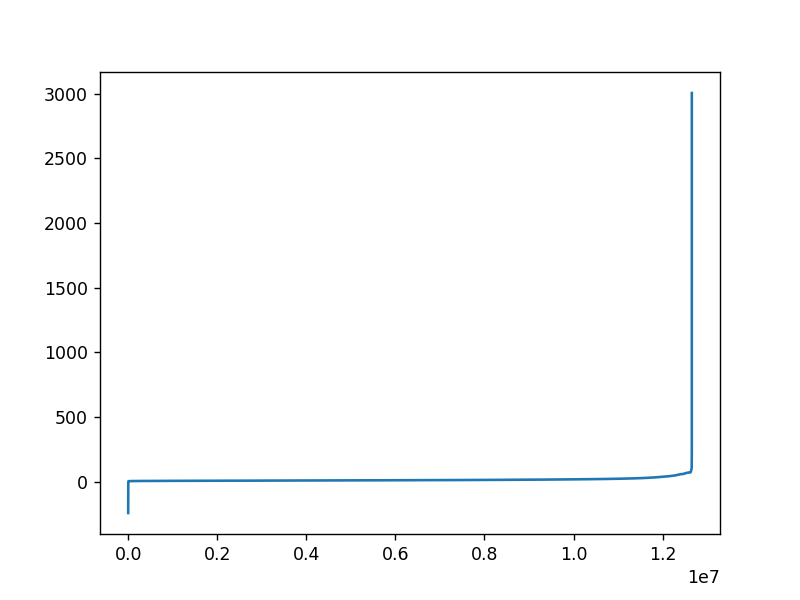

In [35]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
#plot the fare amount excluding last two values in sorted data
plt.plot(trip_fare[:-2])
plt.show()

<IPython.core.display.Javascript object>


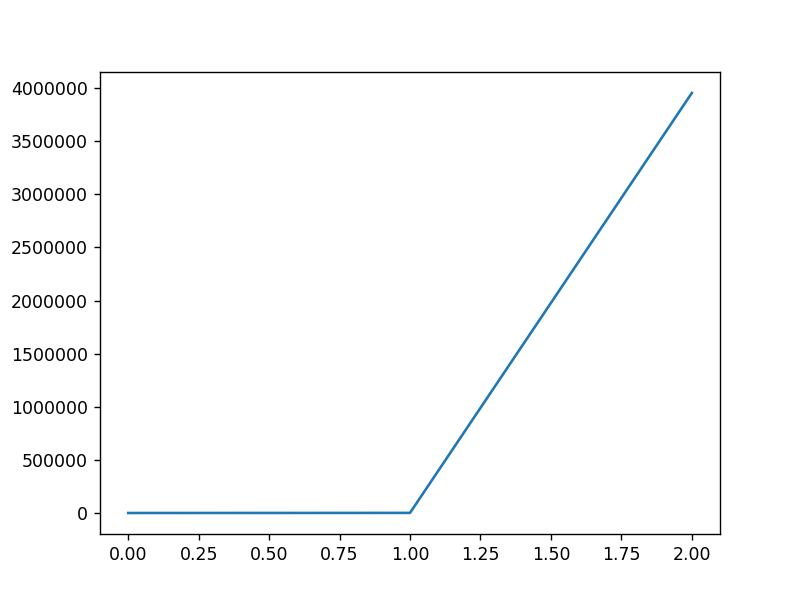

In [36]:
#a very sharp increase in fare values can be seen 
#plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(trip_fare[-3:])
plt.show()

<IPython.core.display.Javascript object>


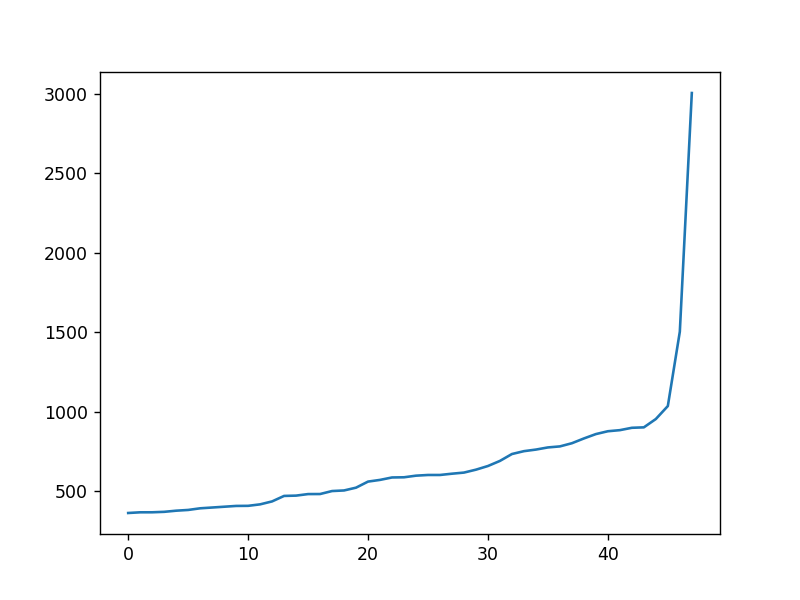

In [37]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
#we plot last 50 values excluding last two values
plt.plot(trip_fare[-50:-2])
plt.show()

<b>Observation:</b> From the above graph, it seems that fare value sharply increse from 1000.

<h3><font color=blue>Remove all Outliers/Erronous Points</font></h3>

In [38]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    a = new_frame.shape[0]
    
    #pick_up_records
    print("Number of Pickup Records =",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    b = temp_frame.shape[0]
    print("Number of Outlier Co-ordinates Lying Outside NY Boundaries:",(a-b))
    #--------------------------------------------------------------------------
    #trip_time
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print("Number of Outliers from Trip Times Analysis:",(a-c))
    #--------------------------------------------------------------------------
    #trip_distance
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print("Number of Outliers from Trip Distance Analysis:",(a-d))
    #--------------------------------------------------------------------------
    #speed
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print("Number of Outliers from Speed Analysis:",(a-e))
    #--------------------------------------------------------------------------
    #trip_fare
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print("Number of Outliers from Trip Fare Analysis:",(a-f))
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)] #trip_time
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)] #trip_distance
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)] #speed
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)] #trip_fare
    
    print("Total Outliers Removed",a - new_frame.shape[0])
    return new_frame

In [39]:
print("-."*20)
print("Removing Outliers in the Month of Jan-2015")
print("-."*20)

frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Removing Outliers in the Month of Jan-2015
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Number of Pickup Records =  12748986
Number of Outlier Co-ordinates Lying Outside NY Boundaries: 293919
Number of Outliers from Trip Times Analysis: 23889
Number of Outliers from Trip Distance Analysis: 92597
Number of Outliers from Speed Analysis: 24473
Number of Outliers from Trip Fare Analysis: 5275
Total Outliers Removed 377910


In [40]:
print("Fraction of Data Points That Remain After Removing Outliers -",float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Fraction of Data Points That Remain After Removing Outliers - 0.9703576425607495


# <font color=green>Data Preparation</font>

<h3><font color=blue>Clustering/Segmentation</font></h3>

In [41]:
#trying different cluster sizes to choose the right K in K-means
#K-means tries to create roughly same size of clusters
#same size of clusters means ~> number of picks are roughly same in all clusters

#we want inter-cluster distances to be less than 2 miles bcz we realize that we can roughly covers 2 miles in about 10 mins
#minimum inter-cluster distance to be > 0.5 miles at least
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
                    
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    
    print("On Choosing a Cluster Size of",cluster_len,"\nAvg Number of Clusters Within the Vicinity (i.e. intercluster-distance < 2):",np.ceil(sum(less2)/len(less2)),"\nAvg Number of Clusters Outside the Vicinity (i.e. intercluster-distance > 2):",np.ceil(sum(more2)/len(more2)),"\nMin Inter-cluster Distance =",min_dist,"\n---")
    
def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000, random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

#we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
#and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)  

On Choosing a Cluster Size of 10 
Avg Number of Clusters Within the Vicinity (i.e. intercluster-distance < 2): 2.0 
Avg Number of Clusters Outside the Vicinity (i.e. intercluster-distance > 2): 8.0 
Min Inter-cluster Distance = 1.0945442325142662 
---
On Choosing a Cluster Size of 20 
Avg Number of Clusters Within the Vicinity (i.e. intercluster-distance < 2): 4.0 
Avg Number of Clusters Outside the Vicinity (i.e. intercluster-distance > 2): 16.0 
Min Inter-cluster Distance = 0.7131298007388065 
---
On Choosing a Cluster Size of 30 
Avg Number of Clusters Within the Vicinity (i.e. intercluster-distance < 2): 8.0 
Avg Number of Clusters Outside the Vicinity (i.e. intercluster-distance > 2): 22.0 
Min Inter-cluster Distance = 0.5185088176172186 
---
On Choosing a Cluster Size of 40 
Avg Number of Clusters Within the Vicinity (i.e. intercluster-distance < 2): 8.0 
Avg Number of Clusters Outside the Vicinity (i.e. intercluster-distance > 2): 32.0 
Min Inter-cluster Distance = 0.50697684503

### Inference:
- The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 40.
- 22.5% of clusters are within 2 miles and minimum inter-cluster distance is 0.5 miles.

In [42]:
#if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
#so we choose 40 clusters for solve the further problem

#getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

<h3><font color=blue>Plotting the Cluster Centers</font></h3>

In [43]:
#plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

<h3><font color=blue>Plotting the Cluster</font></h3>

<IPython.core.display.Javascript object>


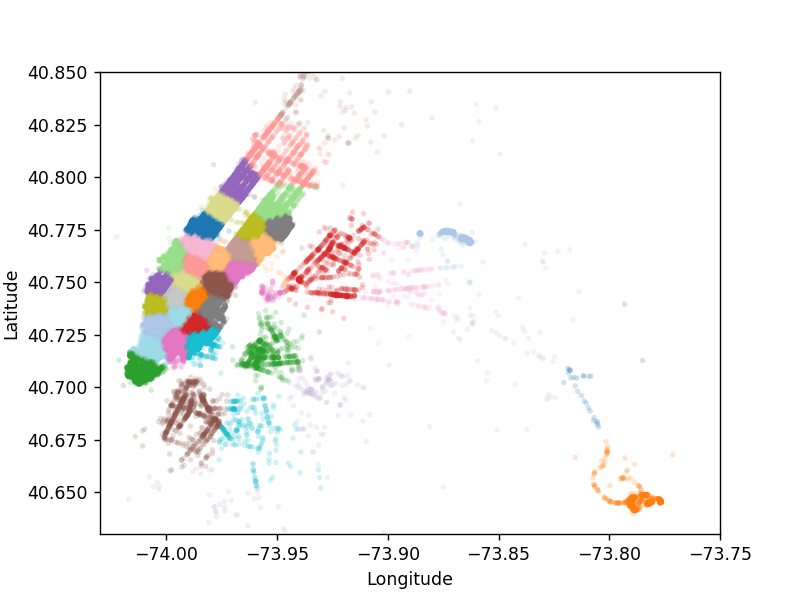

In [44]:
#visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75) #longitude_border
    city_lat_border = (40.63, 40.85) #lattitude_border
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

<h3><font color=blue>Time Binning</font></h3>

In [45]:
#Refer:https://www.unixtimestamp.com/
#1420070400 : 2015-01-01 00:00:00 
#1422748800 : 2015-02-01 00:00:00 
#1425168000 : 2015-03-01 00:00:00
#1427846400 : 2015-04-01 00:00:00 
#1430438400 : 2015-05-01 00:00:00 
#1433116800 : 2015-06-01 00:00:00

#1451606400 : 2016-01-01 00:00:00 
#1454284800 : 2016-02-01 00:00:00 
#1456790400 : 2016-03-01 00:00:00
#1459468800 : 2016-04-01 00:00:00 
#1462060800 : 2016-05-01 00:00:00 
#1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame, month, year):
    unix_pickup_times = [i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    #https://www.timeanddate.com/time/zones/est
    #(int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [46]:
#clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [47]:
#we add two more columns 'pickup_cluster'(to which cluster it belogns to) 
#and 'pickup_bins' (to which 10_min intravel the trip belongs to)
jan_2015_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  pickup_cluster  pickup_bins  
0  1.421329e+09   5.285319              34         2130  
1  1.420902e+09   9.983193               2         1419  
2  1.420902e+09  10.746269              16         1419  
3  1.420902e+09  16.071429              38         1419  
4  1.420902e+09   9.318378              22         1419

In [48]:
#here the trip_distance represents the number of pickups that are happend in that particular 10_min intravel
#this data frame has two indices
#primary index: pickup_cluster (cluster number)
#secondary index: pickup_bins (we devid whole months time into 10_min intervals 24*31*60/10 = 4464_bins)
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                      105
               2                      199
               3                      208
               4                      141
               5                      155

In [49]:
#upto now we cleaned data and prepared data for the month 2015,
#now do the same operations for months Jan, Feb, March of 2016

#1. get the dataframe which inlcudes only required colums
#2. adding trip times, speed, unix time stamp of pickup_time
#3. remove the outliers based on trip_times, speed, trip_duration, total_amount
#4. add pickup_cluster to each data point
#5. add pickup_bin (index of 10min intravel to which that trip belongs to)
#6. group by data, based on 'pickup_cluster' and 'pickuo_bin'

#data Preparation for the months of Jan, Feb and March 2016
def datapreparation(month, kmeans, month_no, year_no):
    
    print("Return With Trip Times...")
    frame_with_durations = return_with_trip_times(month)
    
    print("Remove Outliers...")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print("Estimating Clusters...")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

    print("Final Groupbying...")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed, month_no, year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame, final_groupby_frame
    
month_jan_2016 = dd.read_csv('D:/Applied_Ai/Case Studies/Taxi Demand/yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('D:/Applied_Ai/Case Studies/Taxi Demand/yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('D:/Applied_Ai/Case Studies/Taxi Demand/yellow_tripdata_2016-03.csv')

jan_2016_frame, jan_2016_groupby = datapreparation(month_jan_2016, kmeans, 1, 2016)
feb_2016_frame, feb_2016_groupby = datapreparation(month_feb_2016, kmeans, 2, 2016)
mar_2016_frame, mar_2016_groupby = datapreparation(month_mar_2016, kmeans, 3, 2016)

Return With Trip Times...
Remove Outliers...
Number of Pickup Records =  10906858
Number of Outlier Co-ordinates Lying Outside NY Boundaries: 214677
Number of Outliers from Trip Times Analysis: 27190
Number of Outliers from Trip Distance Analysis: 79742
Number of Outliers from Speed Analysis: 21047
Number of Outliers from Trip Fare Analysis: 4991
Total Outliers Removed 297784
Estimating Clusters...
Final Groupbying...
Return With Trip Times...
Remove Outliers...
Number of Pickup Records =  11382049
Number of Outlier Co-ordinates Lying Outside NY Boundaries: 223161
Number of Outliers from Trip Times Analysis: 27670
Number of Outliers from Trip Distance Analysis: 81902
Number of Outliers from Speed Analysis: 22437
Number of Outliers from Trip Fare Analysis: 5476
Total Outliers Removed 308177
Estimating Clusters...
Final Groupbying...
Return With Trip Times...
Remove Outliers...
Number of Pickup Records =  12210952
Number of Outlier Co-ordinates Lying Outside NY Boundaries: 232444
Number 

<h3><font color=blue>Smoothing</font></h3>

In [50]:
#gets the unique bins where pickup values are present for each each reigion

#for each cluster region we will collect all the indices of 10_min intervals in which the pickups are happened
#we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [51]:
#for every month we get all indices of 10_min intervals in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [52]:
#for each cluster number of 10_min intervals with 0 pickups
for i in range(40):
    print("For the",i,"th Cluster, Number of 10 Min Intavels with Zero Pickups:",4464 - len(set(jan_2015_unique[i])))
    print('.'*60)

For the 0 th Cluster, Number of 10 Min Intavels with Zero Pickups: 41
............................................................
For the 1 th Cluster, Number of 10 Min Intavels with Zero Pickups: 1986
............................................................
For the 2 th Cluster, Number of 10 Min Intavels with Zero Pickups: 30
............................................................
For the 3 th Cluster, Number of 10 Min Intavels with Zero Pickups: 355
............................................................
For the 4 th Cluster, Number of 10 Min Intavels with Zero Pickups: 38
............................................................
For the 5 th Cluster, Number of 10 Min Intavels with Zero Pickups: 154
............................................................
For the 6 th Cluster, Number of 10 Min Intavels with Zero Pickups: 35
............................................................
For the 7 th Cluster, Number of 10 Min Intavels with Zero Pickups: 34
.........

There are two ways to fill up these values:
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [53]:
#fills a value of zero for every bin where no pickup data is present 
#the count_values: number pickps that are happened in each region for each 10_min interval
#there wont be any value if there are no picksups
#values: number of unique bins

#for every 10_min interval(pickup_bin) we will check it is there in our unique bin
#if it is there we will add the count_values[index] to smoothed data
#if not we add 0 to the smoothed data
#we finally return smoothed data

def fill_missing(count_values, values):
    smoothed_regions = []
    ind=0
    for r in range(0,40):
        smoothed_bins = []
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [54]:
#fills a value of zero for every bin where no pickup data is present 
#the count_values: number pickps that are happened in each region for each 10_min interval
#there wont be any value if there are no picksups.
#values: number of unique bins

#for every 10_min interval(pickup_bin) we will check it is there in our unique bin,
#if it is there we will add the count_values[index] to smoothed data
#if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
#we finally return smoothed data

def smoothing(count_values,values):
    smoothed_regions=[] #stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: #prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) #appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing_hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing_hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [55]:
#filling missing values of Jan-2015 with 0
#here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#smoothing missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [56]:
#number of 10_min indices for jan 2015= 24*31*60/10 = 4464
#number of 10_min indices for jan 2016 = 24*31*60/10 = 4464
#number of 10_min indices for feb 2016 = 24*29*60/10 = 4176
#number of 10_min indices for march 2016 = 24*30*60/10 = 4320
#for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("Number of 10 Min Intravels Among All the Clusters -",len(jan_2015_fill))

Number of 10 Min Intravels Among All the Clusters - 178560


<IPython.core.display.Javascript object>


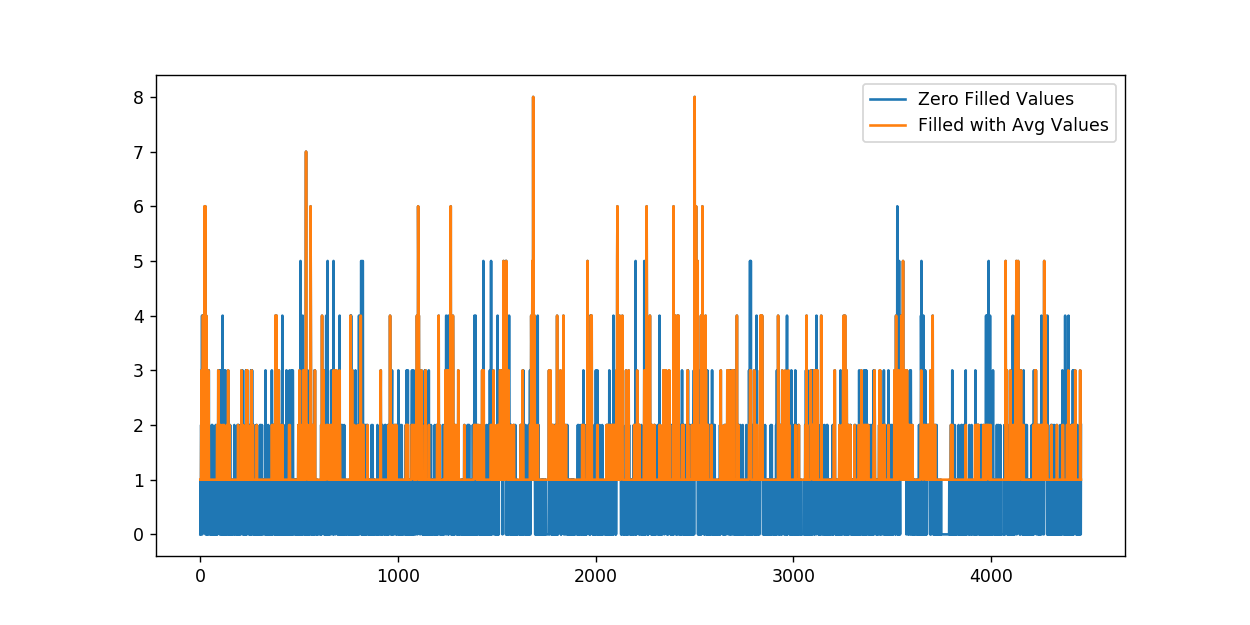

In [57]:
#smoothing vs filling
#sample plot that shows two variations of filling missing values
#we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8920], label="Zero Filled Values")
plt.plot(jan_2015_smooth[4464:8920], label="Filled with Avg Values")
plt.legend()
plt.show()

In [58]:
#why we choose, these methods and which method is used for which data?

#Ans: consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st ~~
#10_min interval, 0 pickups happened in 2nd 10_mins interval, 0 pickups happened in 3rd 10_min interval 
#0 pickups happened in 4th 10_min interval and 20 pickups happened in 5th 10_min interval
#in fill_missing method we replace these values like 10, 0, 0, 0, 20

#where as in smoothing method we replace these values as 6,6,6,6,6 >>> if you can check the number of pickups 
#that are happened in the first 50_min are same in both cases, but if you can observe that we looking at the future values 
#when you are using smoothing we are looking at the future number of pickups which might cause a data leakage

#so we use smoothing for jan 2015 data since it acts as our training data
#and we use simple fill_misssing method for 2016 data i.e., filled with zero

In [59]:
#jan-2015 data is smoothed, Jan, Feb & March 2016 data missing values are filled with zero

jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values, jan_2015_unique)

jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values, jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values, feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values, mar_2016_unique)

#making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

#a =[1,2,3]
#b = [2,3,4]
#a+b = [1, 2, 3, 2, 3, 4]

#number of 10_min indices for jan 2015 = 24*31*60/10 = 4464
#number of 10_min indices for jan 2016 = 24*31*60/10 = 4464
#number of 10_min indices for feb 2016 = 24*29*60/10 = 4176
#number of 10_min indices for march 2016 = 24*31*60/10 = 4464

#regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
#that are happened for three months in 2016 data

for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)] + feb_2016_smooth[4176*i:4176*(i+1)] + mar_2016_smooth[4464*i:4464*(i+1)])

#print(len(regions_cum))
#>>> 40

#print(len(regions_cum[0]))
#>>>13104

<h3><font color=blue>Time Series and Fourier Transforms</font></h3>

<IPython.core.display.Javascript object>


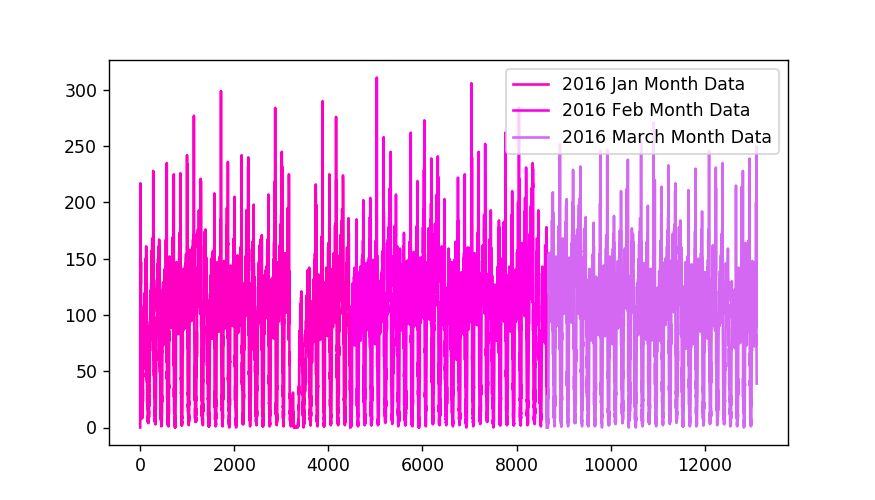

<IPython.core.display.Javascript object>


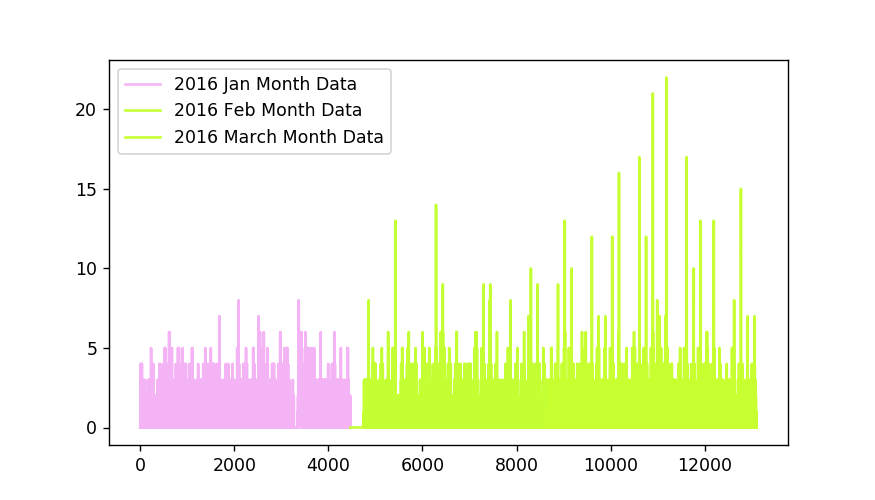

<IPython.core.display.Javascript object>


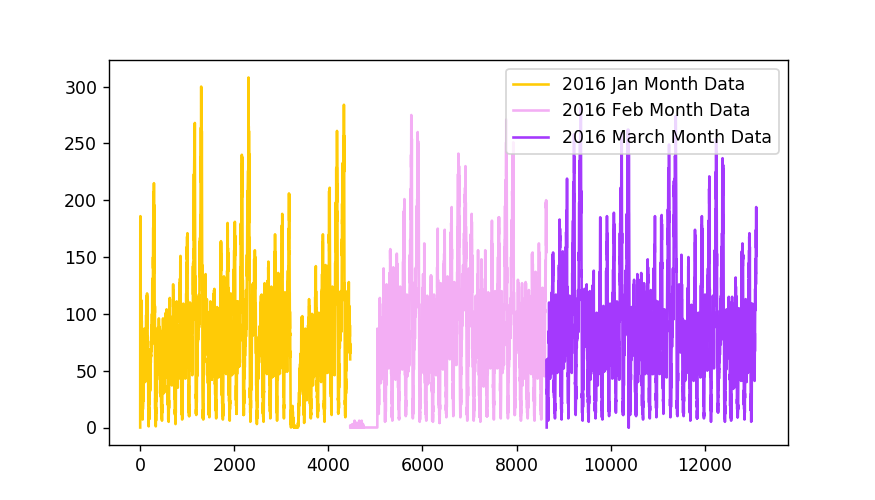

<IPython.core.display.Javascript object>


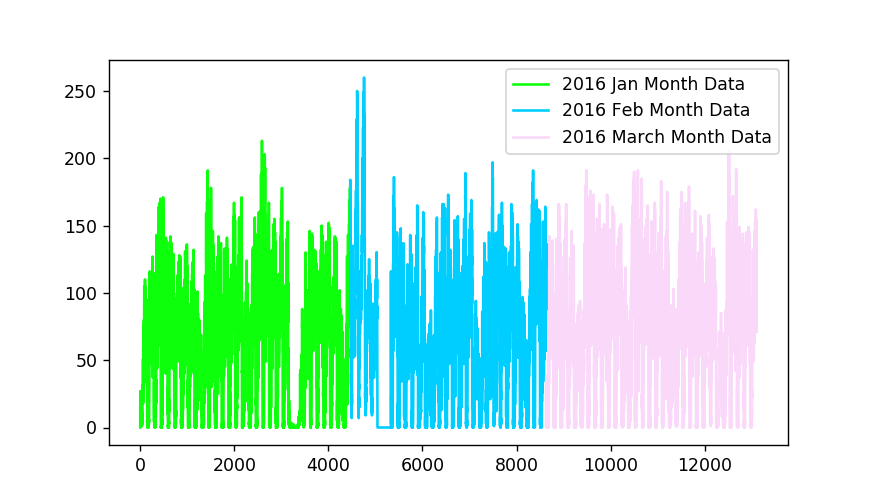

<IPython.core.display.Javascript object>


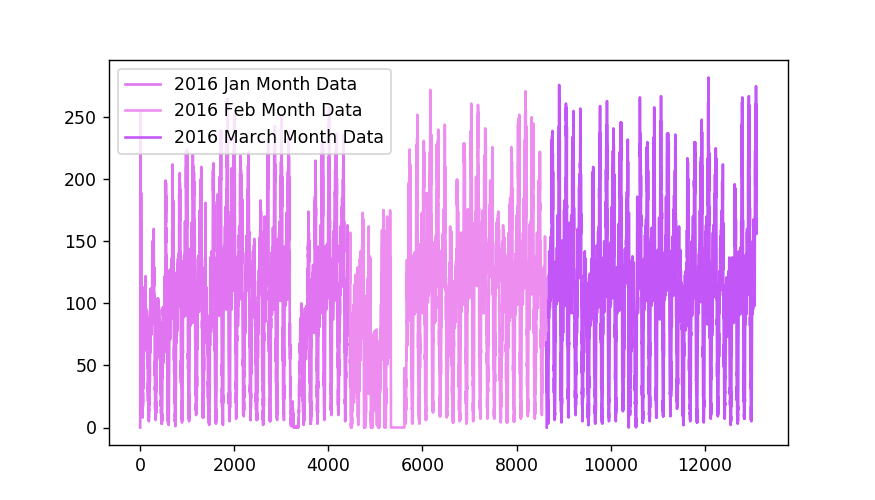

<IPython.core.display.Javascript object>


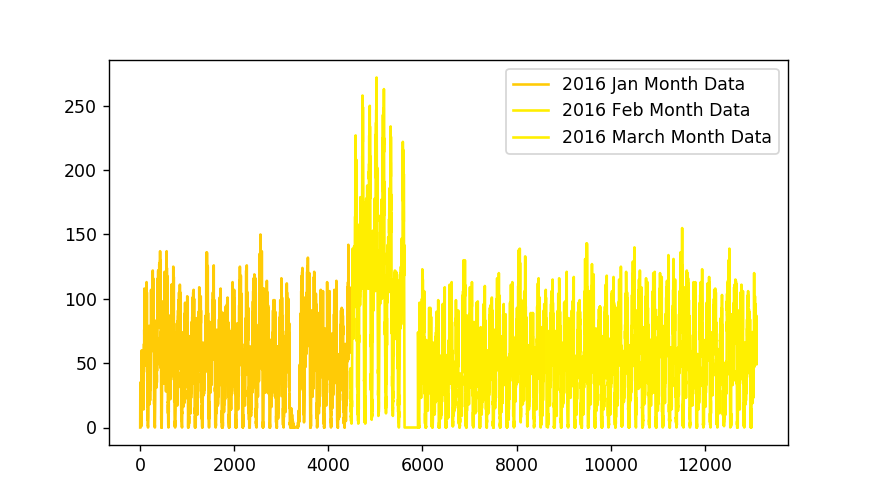

<IPython.core.display.Javascript object>


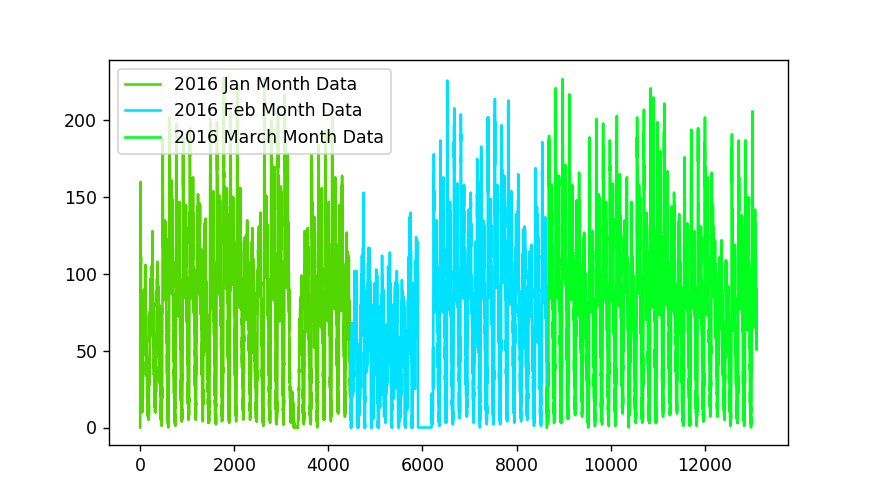

<IPython.core.display.Javascript object>


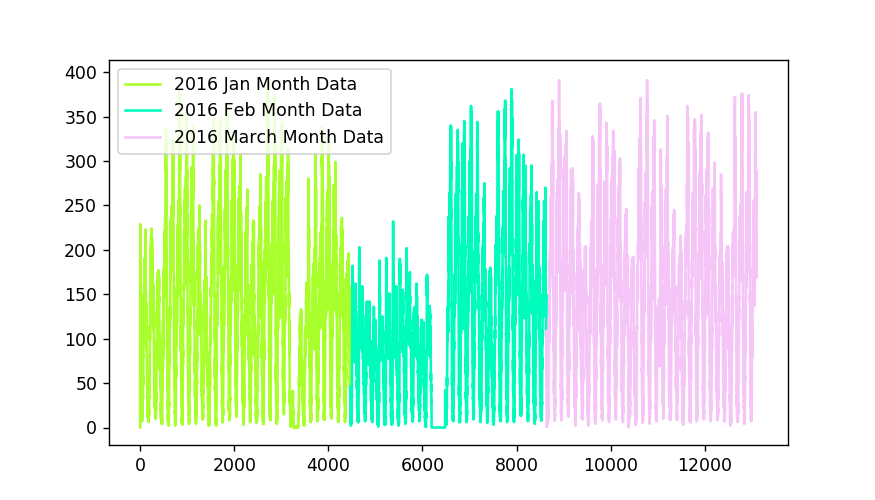

<IPython.core.display.Javascript object>


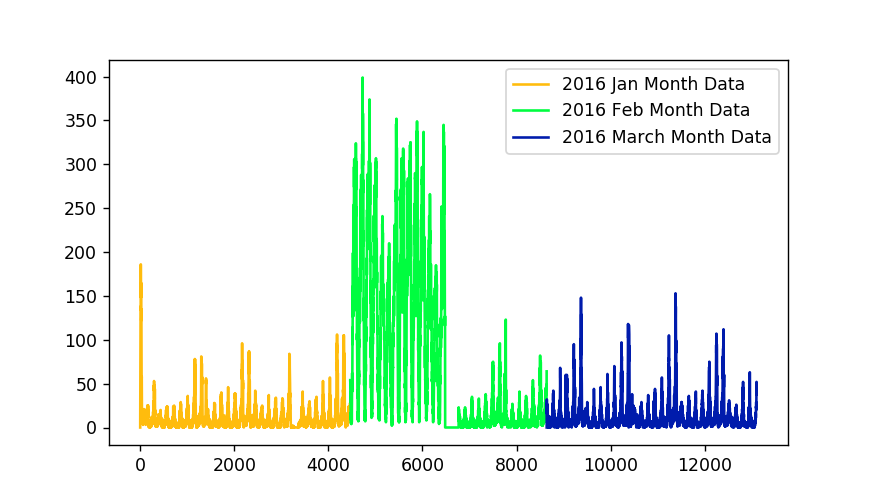

<IPython.core.display.Javascript object>


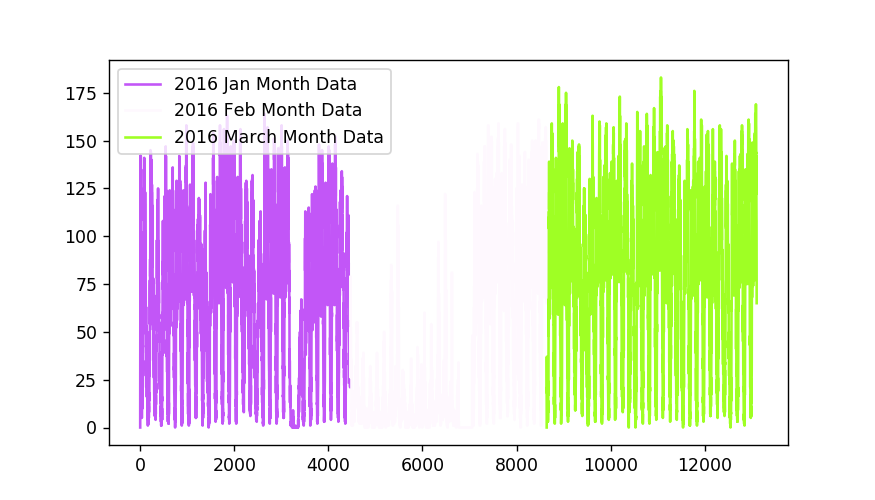

<IPython.core.display.Javascript object>


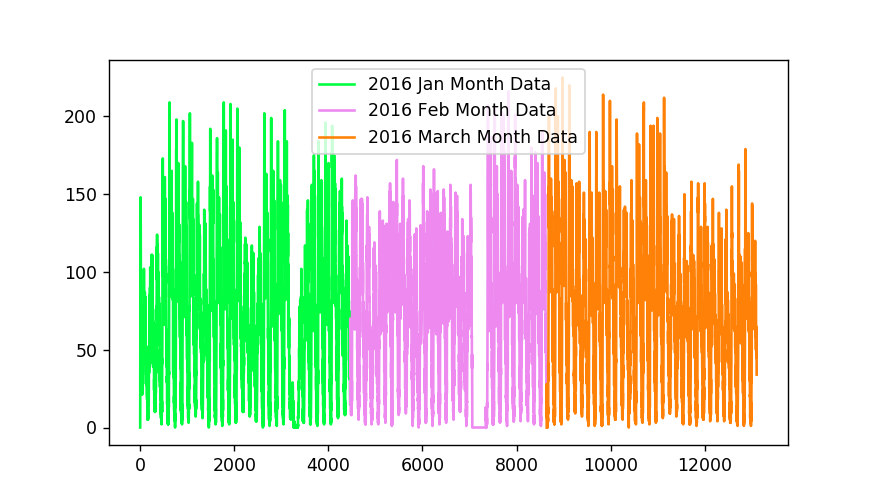

<IPython.core.display.Javascript object>


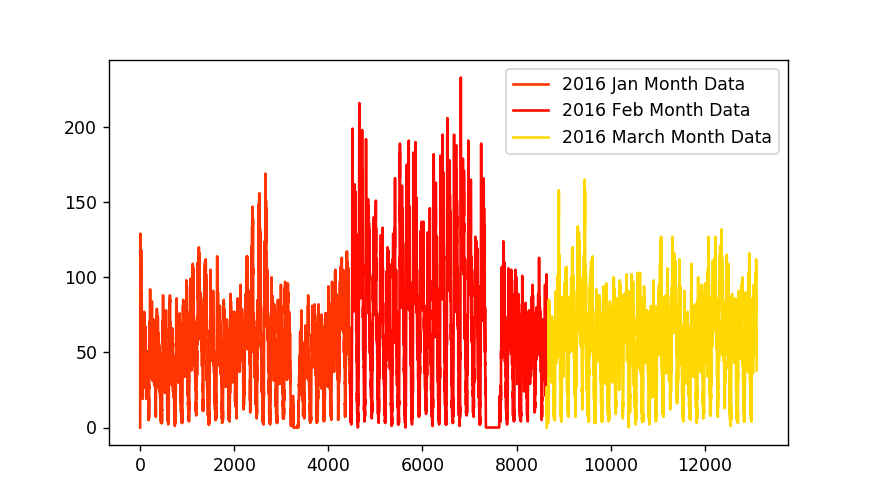

<IPython.core.display.Javascript object>


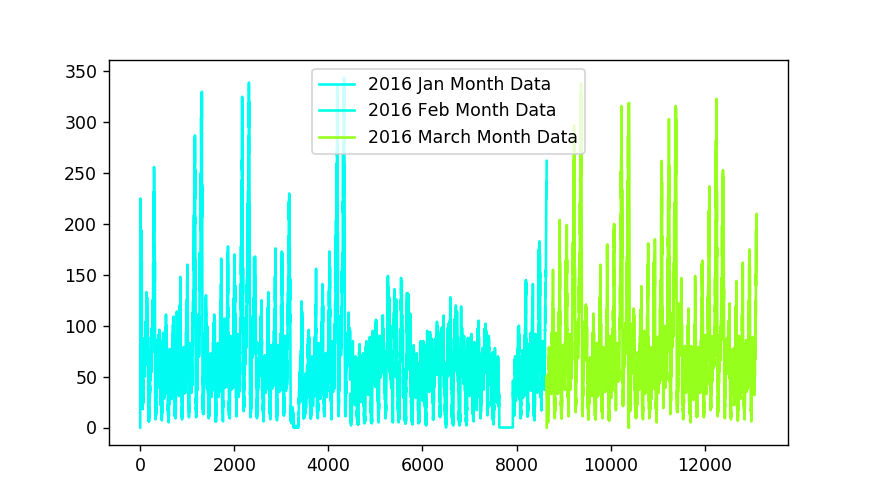

<IPython.core.display.Javascript object>


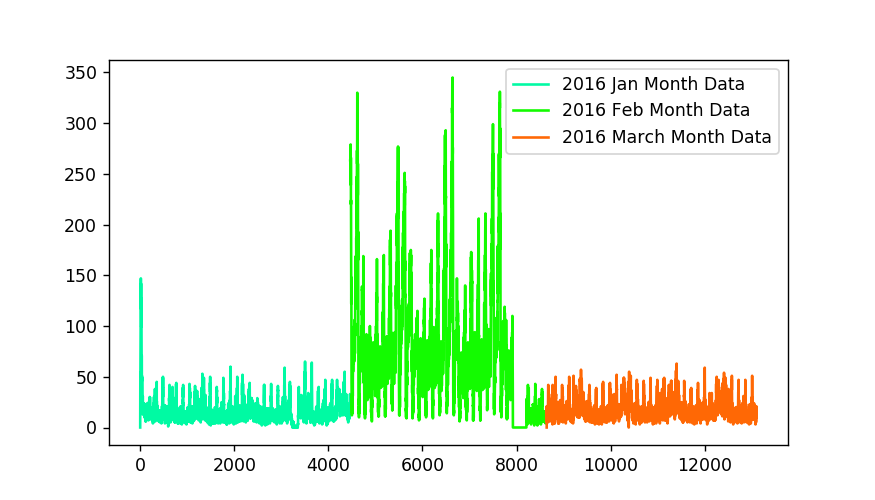

<IPython.core.display.Javascript object>


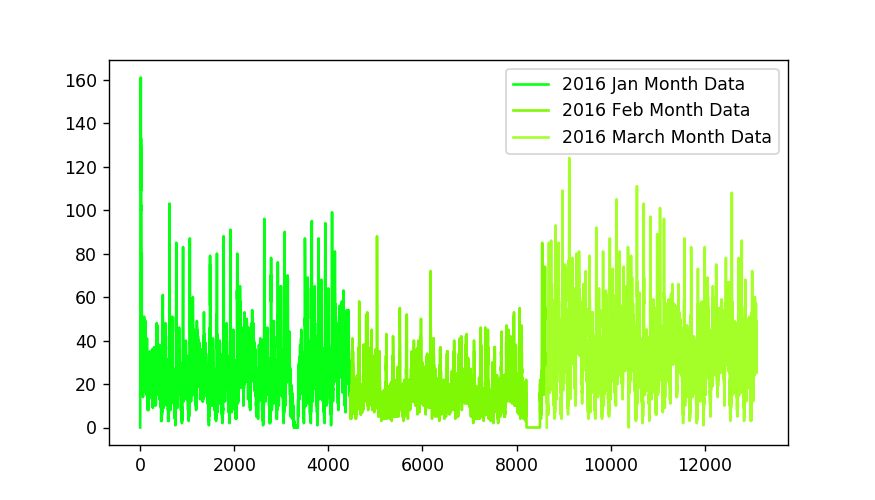

<IPython.core.display.Javascript object>


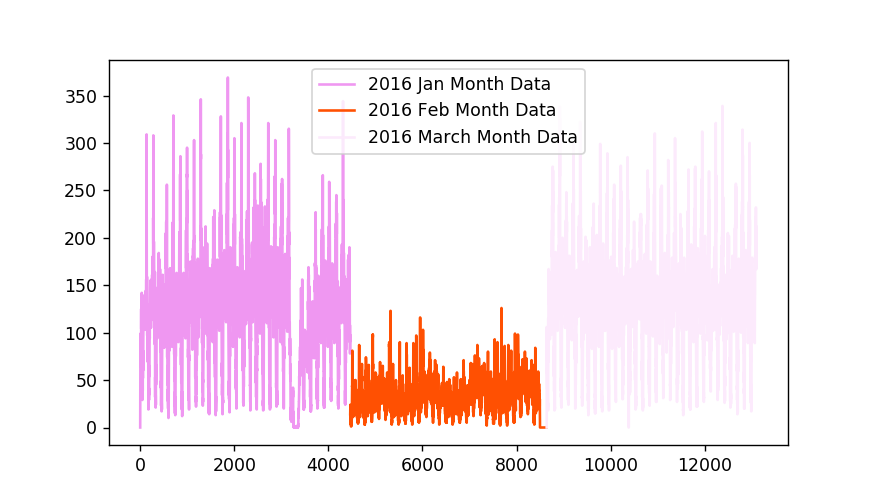

<IPython.core.display.Javascript object>


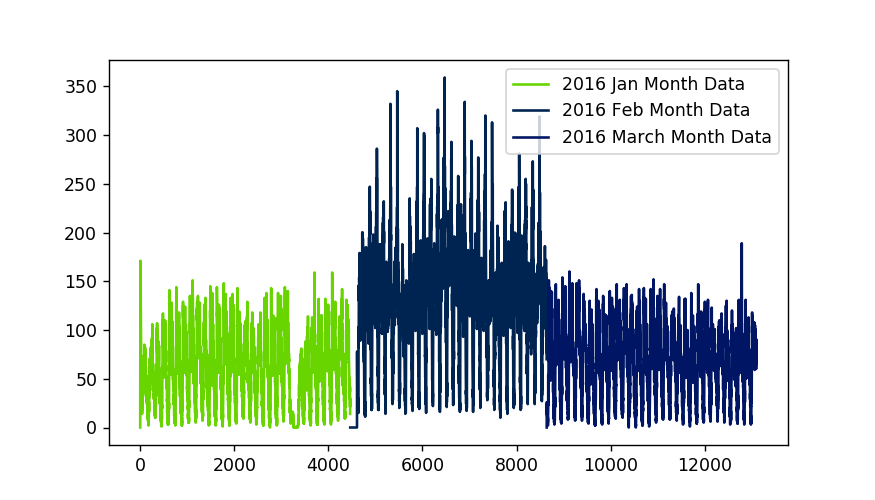

<IPython.core.display.Javascript object>


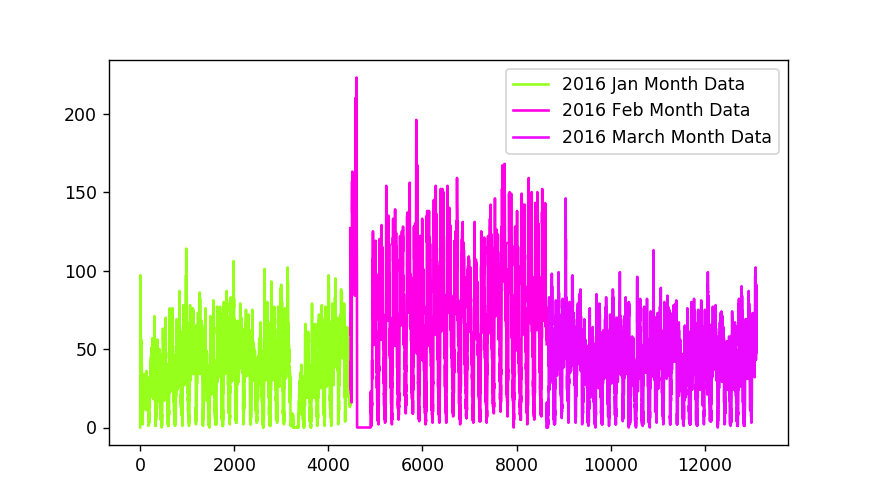

<IPython.core.display.Javascript object>


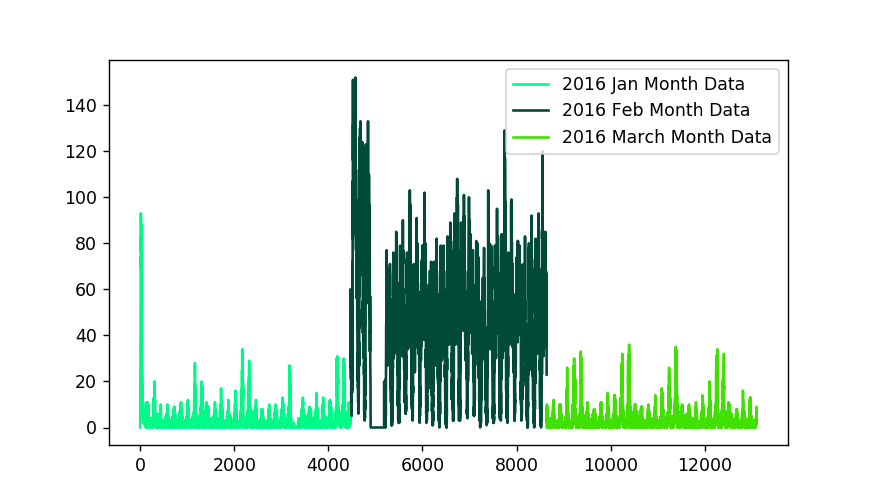

<IPython.core.display.Javascript object>


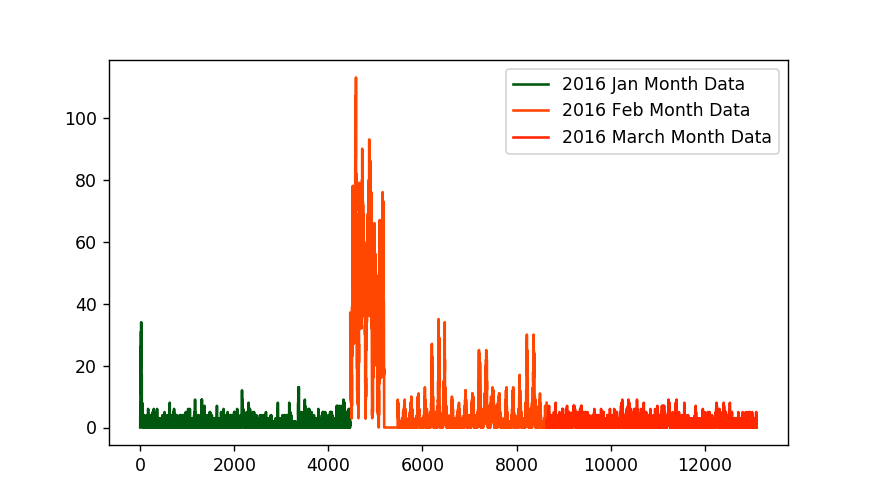

<IPython.core.display.Javascript object>


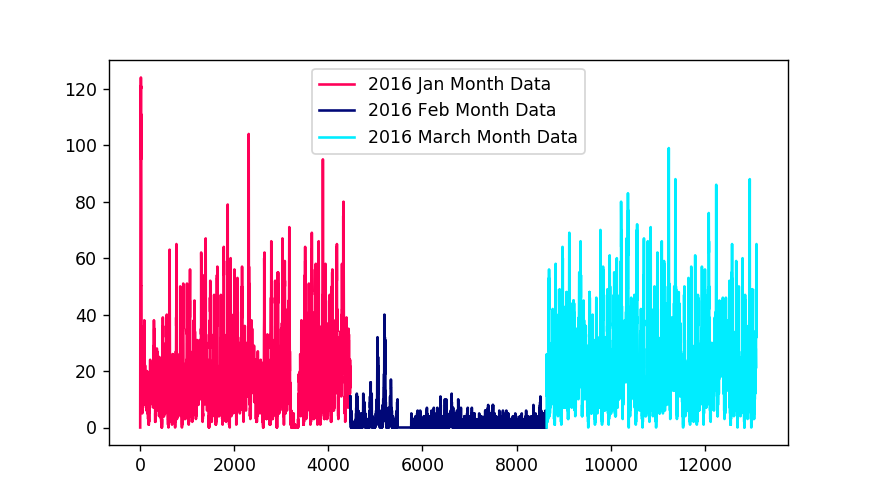

<IPython.core.display.Javascript object>


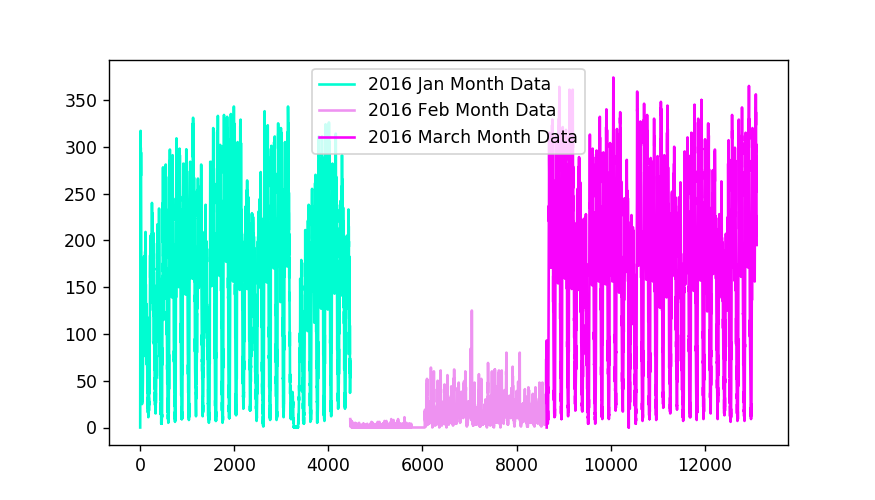

<IPython.core.display.Javascript object>


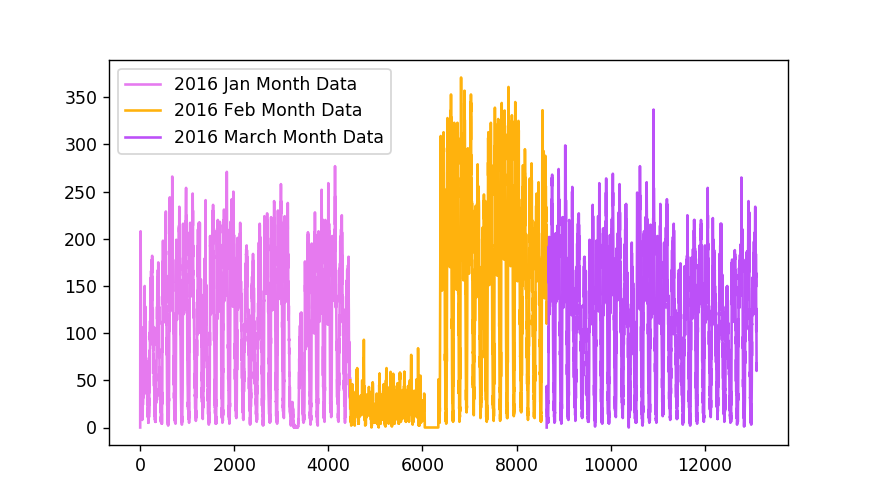

<IPython.core.display.Javascript object>


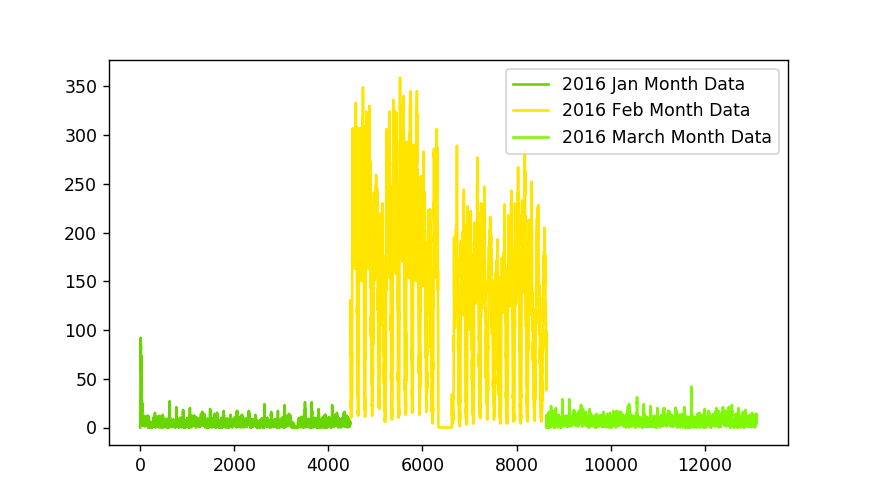

<IPython.core.display.Javascript object>


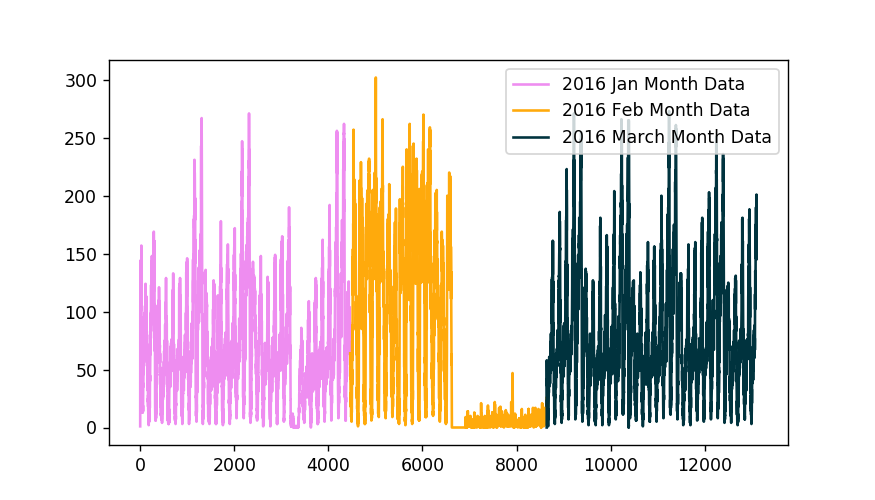

<IPython.core.display.Javascript object>


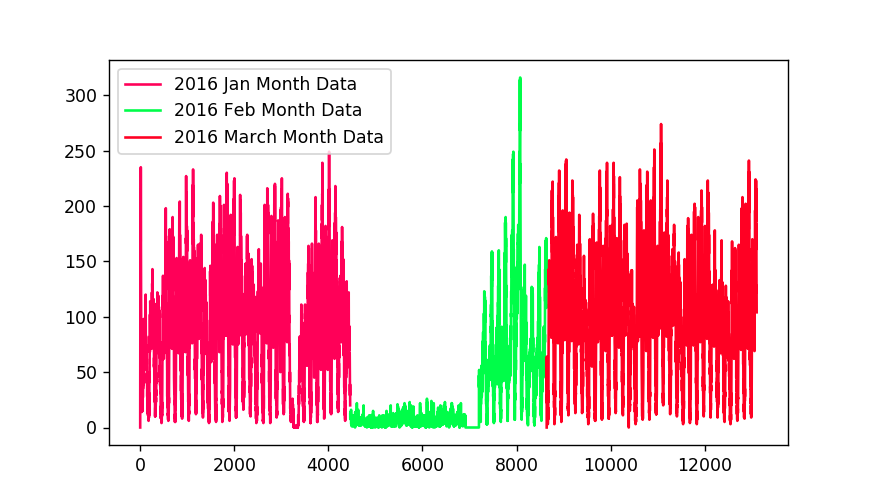

<IPython.core.display.Javascript object>


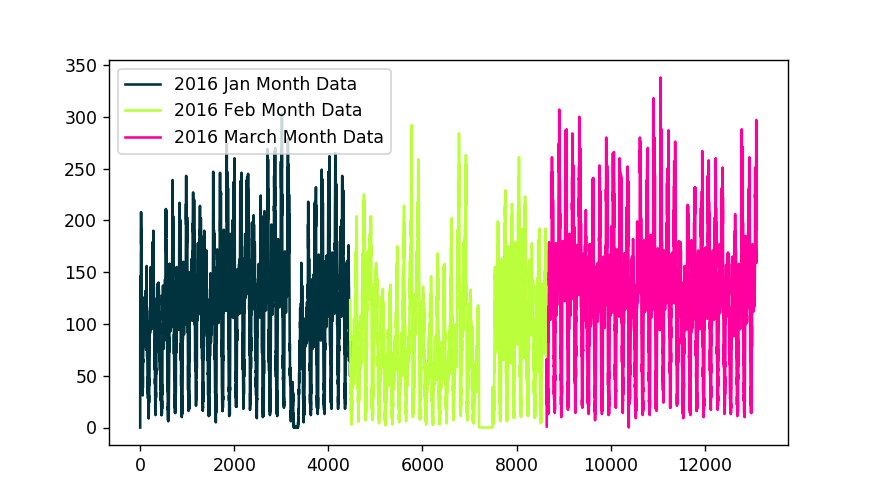

<IPython.core.display.Javascript object>


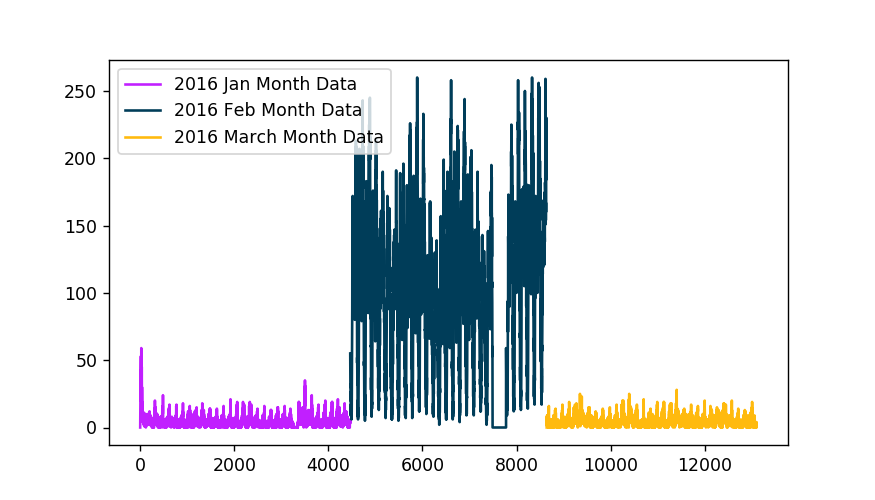

<IPython.core.display.Javascript object>


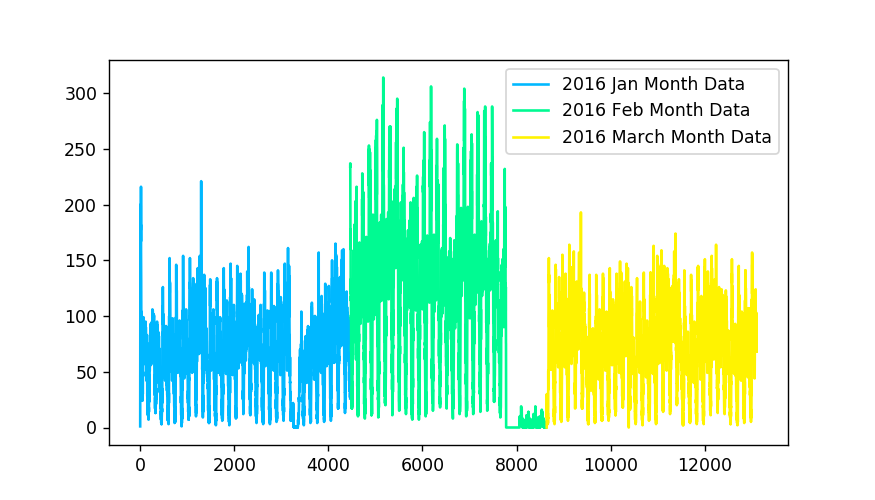

<IPython.core.display.Javascript object>


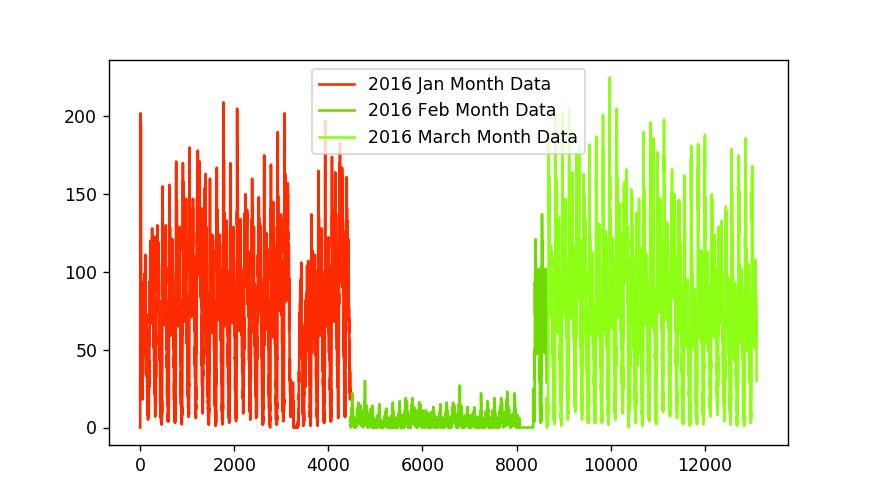

<IPython.core.display.Javascript object>


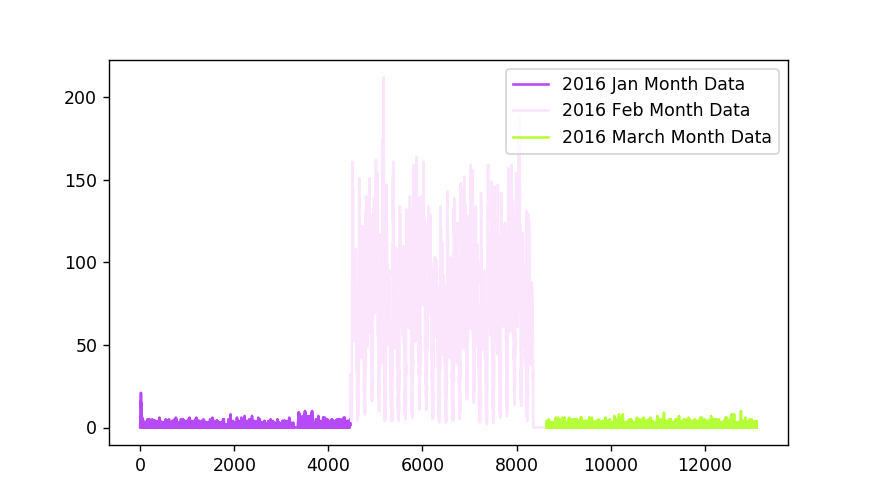

<IPython.core.display.Javascript object>


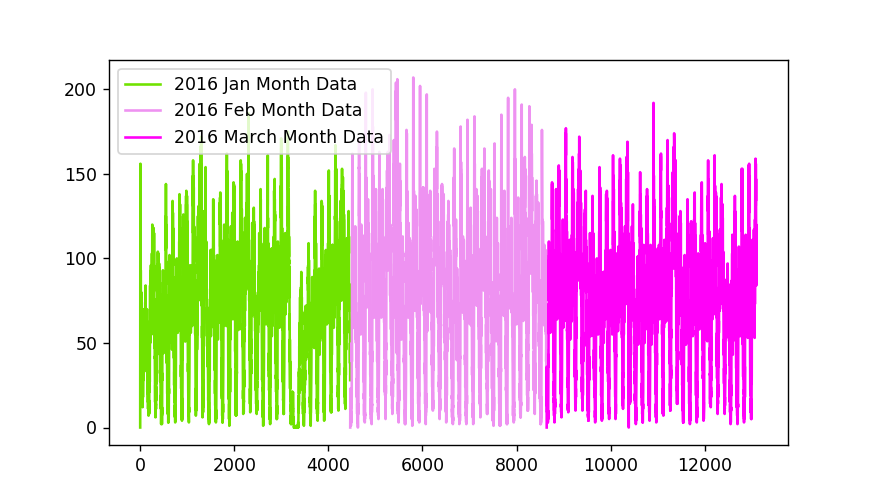

<IPython.core.display.Javascript object>


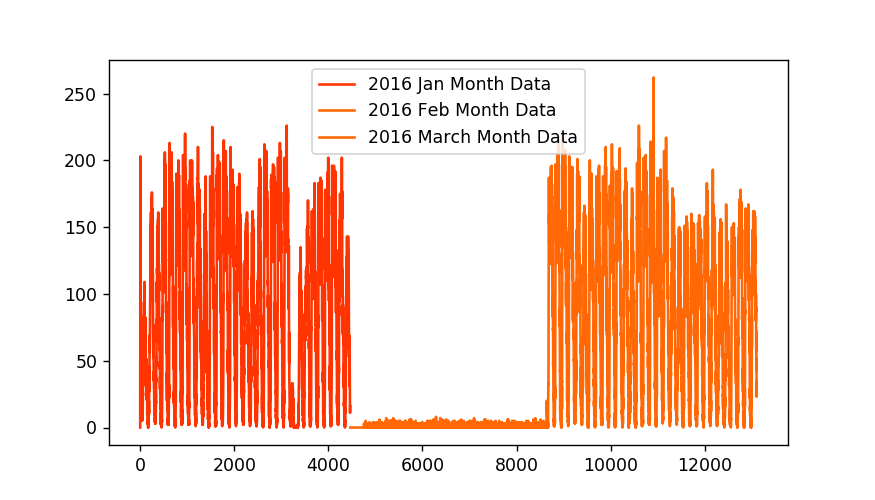

<IPython.core.display.Javascript object>


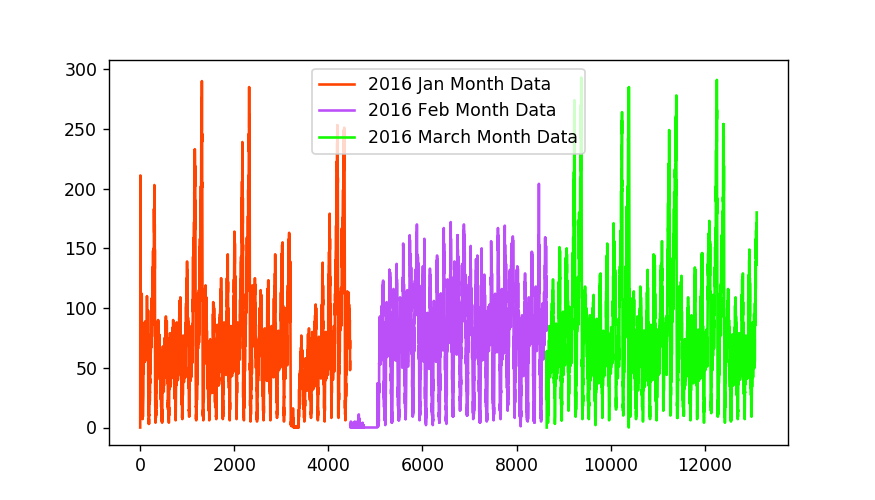

<IPython.core.display.Javascript object>


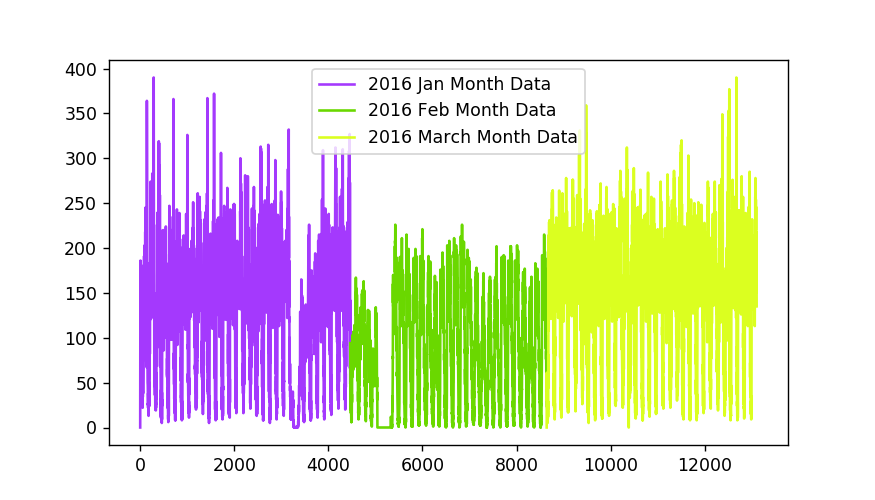

<IPython.core.display.Javascript object>


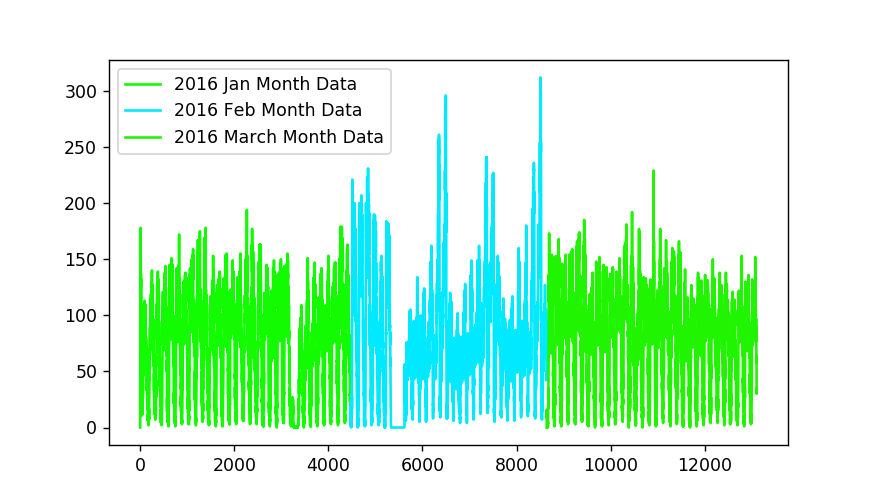

<IPython.core.display.Javascript object>


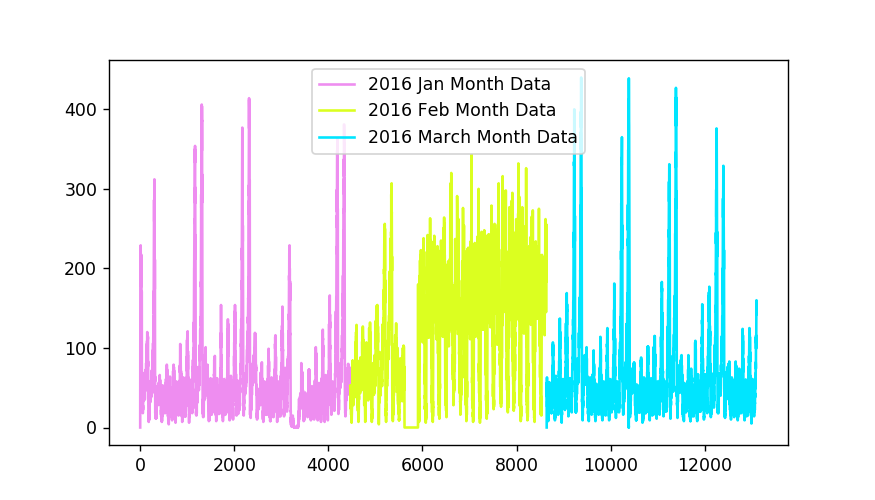

<IPython.core.display.Javascript object>


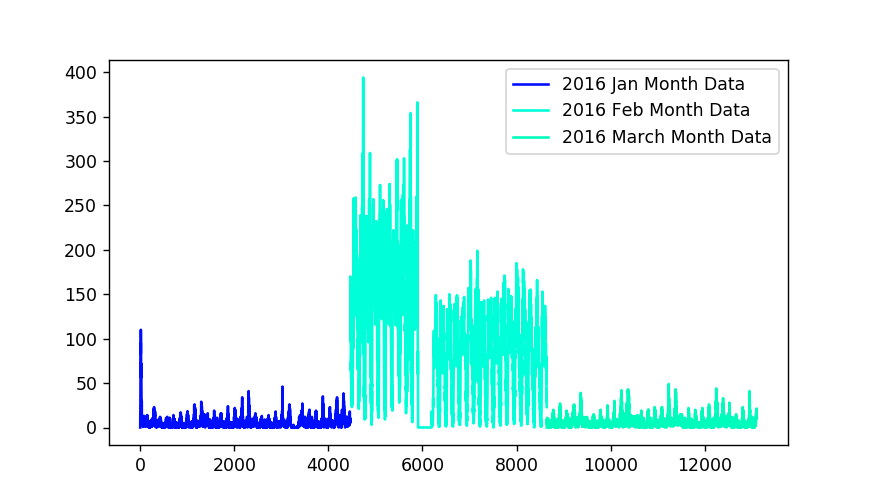

<IPython.core.display.Javascript object>


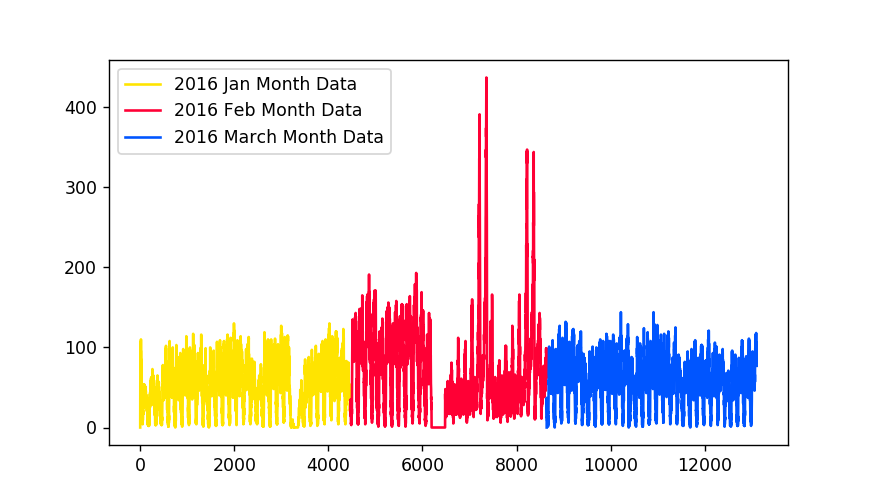

<IPython.core.display.Javascript object>


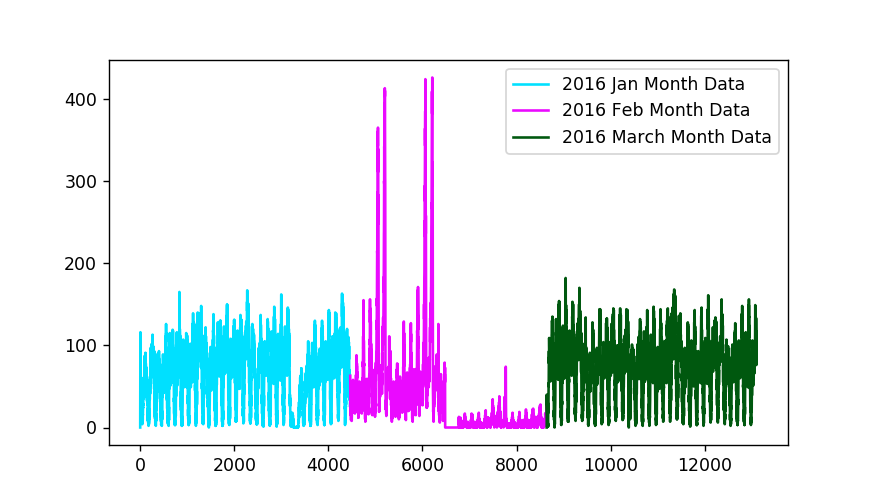

In [60]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())

first_x = list(range(0,4464)) #jan
second_x = list(range(4464,8640)) #feb
third_x = list(range(8640,13104)) #mar

#plot time series graph for each cluster
for i in range(40):
    plt.figure(figsize=(7,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan Month Data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 Feb Month Data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 March Month Data')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


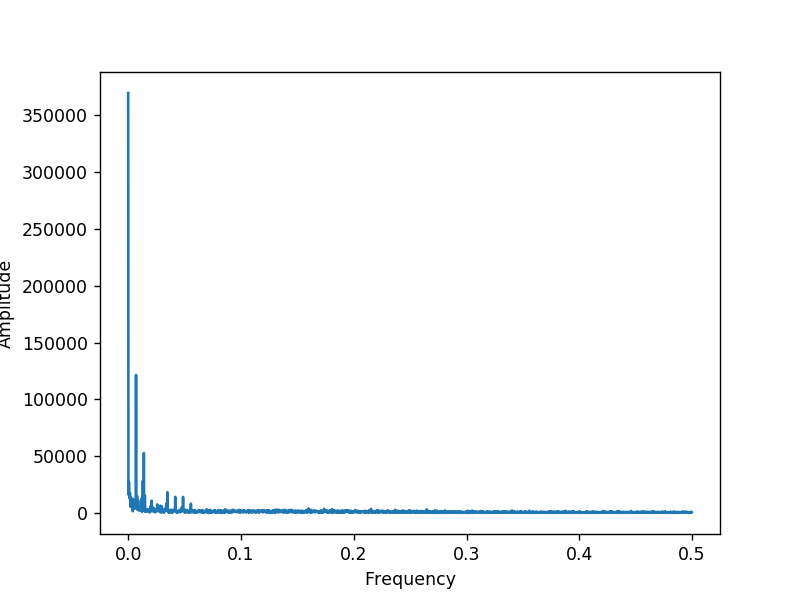

In [61]:
#getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
#read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html

Y = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
#read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html

freq = np.fft.fftfreq(4460, 1)
n = len(freq)

plt.figure()
plt.plot(freq[:int(n/2)], np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [62]:
#if we observe time series graph, the waves are occilating somewhere around middle (not centered at zero)
#thats why pick shown in the FFT graph at zero called as DC-Component; it tells us, that the wave we have is not centered at zero

In [63]:
#preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given'] = jan_2015_smooth
ratios_jan['Prediction'] = jan_2016_smooth
ratios_jan['Ratios'] = ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

# <font color=green>Modelling: Baseline Models</font>

- **Task: Given a Cluster Id at Time t, we want to predict the number of pickups.**

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

In [64]:
#ratio_feature
#if we have data of jan-2015 as training data and jan-2016 is test set; if we somehow know this ratio R at any time t, 
#let time t = 2016 jan-1; 5.30 pm to 5.40 pm; and at time t+1 (5.40 pm to 5.50 pm) at this time if we want to predict pickups
#if we know ratio R_t+1 (if we somehow estimate this ratio); we have P_t+1^2015 value, we can predict P_t+1^2016
##we can use the data from 2015 as a training data here and we can predicted at 2016 as test data by just using the ratios

#previous_known_values_feature
#consider the model is actually running in real world and time to time all the data updated
#all this jan-2016 data; we are not using here jan-2015 data
#let current time t = 2016 jan-1; 5.30 pm to 5.40 pm; 
#and at time t+1 (5.40 pm to 5.50 pm) at this time if we want to predict pickups
#we can build a function uses data at time t, t-1, t-2, t-3,...
#the curves are fairly smooth

#----------------------------------------------------------------------------------------------------
#if we know ratio R_t+1 (if we somehow estimate this ratio); we have P_t+1^2015 value, we can predict P_t+1^2016
#now the big question is how do we get this R_t values
#bcz we we get R_t, then we can calculate P_t^2016
#one simple technique is Simple Moving Averages

### <font color=blue>Simple Moving Averages</font>
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value.<br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [65]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    
    return ratios, mape_err, mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

In [66]:
#just the way we have done simple moving avg for ratios, we can also do simple moving avgs for previous time data

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [67]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    
    return ratios, mape_err, mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 1 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

In [68]:
#the model is right now very simple;
#at any time t if we want to predict number of pickups for a given cluster, we just predict the value at P_t-1

### <font color=blue>Weighted Moving Averages</font>
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones.<br>

In [69]:
#for each of R_t-1 values we gave a weight (N) such that; values which are most recent have a higher weight

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [70]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    
    return ratios, mape_err, mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [71]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    
    return ratios, mape_err, mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2016 values therefore we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

### <font color=blue>Exponential  Weighted Moving Averages</font>

Ref: https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average

Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [72]:
##here we are giving exponentially more weightage to recent points and lesser weightage to the points which are farther away

#R'_t = predicted ratio at time t
#R_t = observed ratio using actual value at time t

#if alpha=0; we are completely ignoring observed value that we have seen at time t-1 and if alpha=1; ignoring predicted value
#find best alpha using hyperparameter search (tuning) that minimizes mean absolute percentage error (MAPE)

In [73]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    
    return ratios, mape_err, mse_err

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [74]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    
    return ratios, mape_err, mse_err

In [75]:
#now we have six simple baseline models

In [76]:
mean_err = [0]*10
median_err = [0]*10

ratios_jan, mean_err[0], median_err[0] = MA_R_Predictions(ratios_jan,'jan')
ratios_jan, mean_err[1], median_err[1] = MA_P_Predictions(ratios_jan,'jan')

ratios_jan, mean_err[2], median_err[2] = WA_R_Predictions(ratios_jan,'jan')
ratios_jan, mean_err[3], median_err[3] = WA_P_Predictions(ratios_jan,'jan')

ratios_jan, mean_err[4], median_err[4] = EA_R1_Predictions(ratios_jan,'jan')
ratios_jan, mean_err[5], median_err[5] = EA_P1_Predictions(ratios_jan,'jan')

### <font color=blue>Comparison Between Baseline Models</font>

We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [82]:
print("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print("-."*20)
print("Moving Averages (Ratios) -                  MAPE:",mean_err[0],"      MSE:",median_err[0])
print("Moving Averages (2016 Values) -             MAPE:",mean_err[1],"      MSE: ",median_err[1])
print("-."*20)
print("Weighted Moving Averages (Ratios) -         MAPE:",mean_err[2],"      MSE:",median_err[2])
print("Weighted Moving Averages (2016 Values) -    MAPE:",mean_err[3],"      MSE:",median_err[3])
print("-."*20)
print("Exponential Moving Averages (Ratios) -      MAPE:",mean_err[4],"      MSE:",median_err[4])
print("Exponential Moving Averages (2016 Values) - MAPE:",mean_err[5],"      MSE:",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Moving Averages (Ratios) -                  MAPE: 0.1821155173392136       MSE: 400.0625504032258
Moving Averages (2016 Values) -             MAPE: 0.14292849686975506       MSE:  174.84901993727598
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Weighted Moving Averages (Ratios) -         MAPE: 0.1784869254376018       MSE: 384.01578741039424
Weighted Moving Averages (2016 Values) -    MAPE: 0.13551088436182082       MSE: 162.46707549283155
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Exponential Moving Averages (Ratios) -      MAPE: 0.17783550194861494       MSE: 378.34610215053766
Exponential Moving Averages (2016 Values) - MAPE: 0.1350915263669572       MSE: 159.73614471326164


<b>Plese Note:</b> The above comparisons are made using Jan 2015 and Jan 2016 only.

From the above matrix it is inferred that the best forecasting model for our prediction would be:
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e Exponential Moving Averages using 2016 Values.

# <font color=green>Regression Models</font>

### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [83]:
#preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
#number of 10min indices for jan 2015= 24*31*60/10 = 4464
#number of 10min indices for jan 2016 = 24*31*60/10 = 4464
#number of 10min indices for feb 2016 = 24*29*60/10 = 4176
#number of 10min indices for march 2016 = 24*31*60/10 = 4464
#regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
#that are happened for three months in 2016 data

#we take number of pickups that are happened in last 5 (10_min) intravels
number_of_time_stamps = 5

#output variable
#it is list of lists
#it will contain number of pickups 13099 for each cluster
output = []

#tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
#ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
#it is list of lists
tsne_lat = []

#tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
#ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
#it is list of lists
tsne_lon = []

#we will code each day 
#sunday=0, monday=1, tuesday=2, wednesday=3, thursday=4, friday=5, satursday=6
#for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
#it is list of lists
tsne_weekday = []

#its an numpy array, of shape (523960, 5)
#each row corresponds to an entry in out data
#for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
#the second row will have [f1,f2,f3,f4,f5]
#the third row will have [f2,f3,f4,f5,f6]
#and so on...
tsne_feature = []

tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    #jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    #our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    #regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
    
tsne_feature = tsne_feature[1:]

In [84]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 40*13099 == len(output)*len(output[0])

True

In [85]:
#getting the predictions of exponential moving averages to be used as a feature in cumulative form

#upto now we computed 8 features for every data point that starts from 50th min of the day
#1. cluster center lattitude
#2. cluster center longitude
#3. day of the week 
#4. f_t_1: number of pickups that are happened previous t-1th 10min interval
#5. f_t_2: number of pickups that are happened previous t-2th 10min interval
#6. f_t_3: number of pickups that are happened previous t-3th 10min interval
#7. f_t_4: number of pickups that are happened previous t-4th 10min interval
#8. f_t_5: number of pickups that are happened previous t-5th 10min interval

#from the baseline models we said the exponential weighted moving avarage gives us the best error
#we will try to add the same exponential weighted moving avarage at t as a feature to our data
#exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

#it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
#for each cluster it will get reset
#for every cluster it contains 13104 values
predicted_values=[]

#it is similar like tsne_lat
#it is list of lists
#predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [86]:
#train, test split : 70% 30% split
#before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
#and split it such that for every region we have 70% data in train and 30% in test,
#ordered date-wise for every region
print("size of Train Data :", int(13099*0.7))
print("size of Test Data :", int(13099*0.3))

size of Train Data : 9169
size of Test Data : 3929


In [87]:
#extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
#temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [90]:
print("Number of Data Clusters (Train)",len(train_features)) 
print("Number of Data Points in Train Data",len(train_features[0]),"& Each Data Point Contains",len(train_features[0][0]),"Features.")
print("-."*10)
print("Number of Data Clusters (Test)",len(test_features))
print("Number of Data Points in Test Data",len(test_features[0]),"& Each Data Point Contains",len(test_features[0][0]),"Features.")

Number of Data Clusters (Train) 40
Number of Data Points in Train Data 9169 & Each Data Point Contains 5 Features.
-.-.-.-.-.-.-.-.-.-.
Number of Data Clusters (Test) 40
Number of Data Points in Test Data 3930 & Each Data Point Contains 5 Features.


In [91]:
#train
#extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [92]:
#test
#extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [93]:
#the above contains the values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
    
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [94]:
#converting lists of lists into sinle list i.e flatten
#a = [[1,2,3,4],[4,6,7,8]]
#print(sum(a,[]))
#>>>[1, 2, 3, 4, 4, 6, 7, 8]

#train
tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [95]:
#test
tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [96]:
#preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(366760, 9)


In [97]:
#preparing the data frame for our test data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg

print(df_test.shape)

(157200, 9)


In [98]:
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg
0   118   106   104    93   102  40.776228 -73.982119        4      100
1   106   104    93   102   101  40.776228 -73.982119        4      100
2   104    93   102   101   120  40.776228 -73.982119        4      114
3    93   102   101   120   131  40.776228 -73.982119        4      125
4   102   101   120   131   164  40.776228 -73.982119        4      152

## <font color=blue>Linear Regression Model</font>

In [127]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]

y_pred = lr.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

cv_score = cross_val_score(lr_reg, df_train, tsne_train_output, cv=5, scoring='r2')

print("CV Score:",np.mean(cv_score))

CV Score: 0.9565872064023863


## <font color=blue>Random Forest Regressor</font>

In [135]:
from sklearn.ensemble import RandomForestRegressor

regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [139]:
#predicting on test data using our trained random forest model 

#the models regr1 is already hyper parameter tuned
#the parameters that we got above are found using grid search
y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]

y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [140]:
#feature importances based on analysis using random forest
print(df_train.columns)
print(regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[0.05260979 0.05704881 0.13106873 0.18165379 0.19931505 0.00228002
 0.00297325 0.00164471 0.37140585]


## <font color=blue>XgBoost Regressor</font>

In [141]:
import xgboost as xgb

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)

x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=200, reg_lambda=200, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [142]:
#predicting with our trained Xg-Boost regressor
#the models x_model is already hyper parameter tuned
#the parameters that we got above are found using grid search
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]

y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [144]:
#feature importances
x_model.get_booster().get_score(importance_type='weight')

{'ft_5': 1062.0,
 'ft_4': 754.0,
 'ft_3': 809.0,
 'ft_2': 1010.0,
 'ft_1': 1083.0,
 'lat': 596.0,
 'lon': 602.0,
 'weekday': 206.0,
 'exp_avg': 775.0}

### <font color=blue>Calculating the Error Metric Values for Various Models</font>

In [145]:
from sklearn.metrics import mean_absolute_error

train_mape=[]
test_mape=[]

#train~>>mean_abs_per_error
#baseline model
train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))

#exponential averages forecasting
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))

#linear regression
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

#random forest
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

#xgboost
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

#test~>>mean_abs_per_error
#baseline model
test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))

#exponential averages forecasting
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))

#linear regression
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

#random forest
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

#xgboost
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [148]:
print("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print("-."*40)
print("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print("Linear Regression -                          Train: ",train_mape[2],"      Test: ",test_mape[2])
print("Random Forest Regression -                   Train: ",train_mape[3],"      Test: ",test_mape[3])
print("XgBoost Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print("-."*40)

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Baseline Model -                             Train:  0.14005275878666593       Test:  0.13653125704827038
Exponential Averages Forecasting -           Train:  0.13289968436017227       Test:  0.12936180420430524
Linear Regression -                          Train:  0.13331572016045437       Test:  0.1291202994009687
Random Forest Regression -                   Train:  0.09171617673080142       Test:  0.12724216232333926
XgBoost Regression -                         Train:  0.12940882506016196       Test:  0.12692974475226404
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
